In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Keras
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation

# データの分割
from sklearn.model_selection import train_test_split

# MSE
from sklearn.metrics import mean_squared_error

%matplotlib inline

pd.options.display.max_columns = None

In [2]:
dataset_base = pd.read_csv('baseball_salary.csv')
dataset_base.head()

,球団,推定年俸,守備,年数,年齢,身長,体重,血液型,投打,年,打率,試合,打席数,打数,安打,本塁打,打点,盗塁,四球,死球,三振,犠打,併殺打,出塁率,長打率,OPS,RC27,XR27,球団勝率,プレーオフ,球団平均得点,球団打率
0,c,21000,外野手,11,29,177,90,AB型,右左,2017,0.308,143,651,556,171,23,92,13,83,4,113,2,6,0.398,0.505,0.903,7.70,7.52,0.633,2,5.15,0.273
1,c,19000,内野手,7,28,171,72,A型,右右,2017,0.271,138,629,565,153,14,56,8,32,1,107,30,9,0.311,0.405,0.716,4.10,4.01,0.633,2,5.15,0.273
2,c,14000,内野手,5,29,171,85,A型,右左,2017,0.290,143,679,565,164,8,60,35,89,15,120,6,5,0.398,0.407,0.805,6.41,6.26,0.633,2,5.15,0.273
3,c,11500,内野手,7,38,196,126,不明,右右,2017,0.265,116,405,344,91,27,78,0,50,8,111,0,8,0.368,0.532,0.900,6.80,6.90,0.633,2,5.15,0.273
4,c,11000,内野手,20,41,189,102,B型,右右,2017,0.292,100,288,243,71,9,48,2,40,1,56,0,7,0.389,0.461,0.850,6.55,6.54,0.633,2,5.15,0.273


In [3]:
dataset = dataset_base[['推定年俸', '打点', '年数', '打率', '本塁打', '球団勝率']]

# 列名をリネーム
dataset = dataset.rename(columns={'推定年俸':'salary', '打点':'points', '年数':'years_exp', \
                                  '打率':'batting', '本塁打':'homerun', '球団勝率':'team_win'})
dataset.head()

,salary,points,years_exp,batting,homerun,team_win
0,21000,92,11,0.308,23,0.633
1,19000,56,7,0.271,14,0.633
2,14000,60,5,0.290,8,0.633
3,11500,78,7,0.265,27,0.633
4,11000,48,20,0.292,9,0.633


In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
dataset_std = sc.fit_transform(dataset)
dataset_std.shape

(241, 6)

In [5]:
Y = dataset_std[:, 0]

X = dataset_std[:, 1:]
print('Y:', Y.shape)
print('X:', X.shape)

Y: (241,)
X: (241, 5)


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [7]:
print('Y_train=', Y_train.shape, ', X_train=', X_train.shape)
print('Y_valid=', Y_valid.shape, ', X_valid=', X_valid.shape)
print('Y_test=', Y_test.shape, ', X_test=', X_test.shape)

Y_train= (117,) , X_train= (117, 5)
Y_valid= (51,) , X_valid= (51, 5)
Y_test= (73,) , X_test= (73, 5)


In [8]:
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Dense(8, activation='relu', input_shape=(5,)))
# 隠れ層
model.add(Dense(8, activation='relu'))
# 出力層
model.add(Dense(1))

# モデルの構築
model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [10]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=5000, batch_size=48, verbose=False,
               validation_data=(X_valid, Y_valid))

CPU times: user 1min 8s, sys: 1.77 s, total: 1min 10s
Wall time: 1min 10s


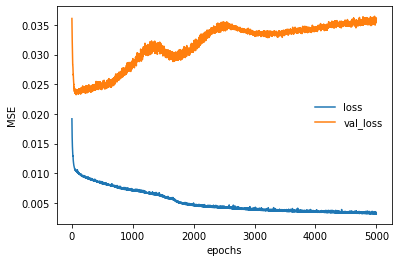

In [11]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.show()

In [12]:
# モデルの作成
model = keras.Sequential()
model.add(Dense(8, activation='relu', input_shape=(5,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=64, verbose=False,
               callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0, patience=100,
                                                        verbose=1)],
               validation_data=(X_valid, Y_valid))

Epoch 00384: early stopping


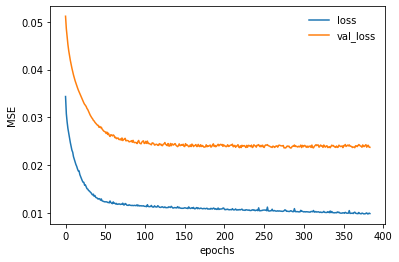

In [13]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.show()

In [14]:
Y_pred = model.predict(X_test)

In [15]:
Y_test_ = sc.inverse_transform(np.hstack([Y_test.reshape(len(Y_test), 1), X_test]))[:, 0]
Y_pred_ = sc.inverse_transform(np.hstack([Y_pred.reshape(len(Y_pred), 1), X_test]))[:, 0]

In [16]:
mse = mean_squared_error(Y_test_, Y_pred_)
print('MSE(Keras回帰モデル)：', mse)

MSE(Keras回帰モデル)： 41898978.819257595


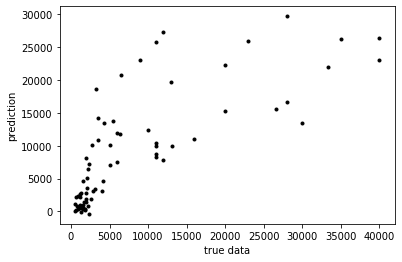

In [17]:
plt.plot(Y_test_, Y_pred_, 'k.')
plt.xlabel('true data')
plt.ylabel('prediction')
plt.show()

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()

In [19]:
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# datasetの作成
dataset = pd.DataFrame(data=iris['data'], columns= feature_names)
dataset['species'] = iris['target']
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [20]:
# setosaかそれ以外か
is_setosa = (dataset['species'] == 0).astype(np.int64)

# datasetに追加
dataset['is_setosa'] = is_setosa
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species,is_setosa
0,5.1,3.5,1.4,0.2,0,1
1,4.9,3.0,1.4,0.2,0,1
2,4.7,3.2,1.3,0.2,0,1
3,4.6,3.1,1.5,0.2,0,1
4,5.0,3.6,1.4,0.2,0,1


In [21]:
# 目的変数(Y)：is_setosa、説明変数(X)：petal_widthとpetal_length
Y = np.array(dataset['is_setosa'])
X = np.array(dataset[['petal_width', 'petal_length']])

In [22]:
print('Y=', Y.shape, ', X=', X.shape)

Y= (150,) , X= (150, 2)


In [23]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [24]:
# 形状を確認
print('Y_train=', Y_train.shape, ', X_train=', X_train.shape)
print('Y_valid=', Y_valid.shape, ', X_valid=', X_valid.shape)
print('Y_test=', Y_test.shape, ', X_test=', X_test.shape)

Y_train= (73,) , X_train= (73, 2)
Y_valid= (32,) , X_valid= (32, 2)
Y_test= (45,) , X_test= (45, 2)


In [25]:
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Dense(8, activation='relu', input_shape=(2,)))
# 隠れ層
model.add(Dense(8, activation='relu'))
# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
model.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=5000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=100,
                                                         verbose=1)],
                validation_data=(X_valid, Y_valid))

Train on 73 samples, validate on 32 samples
Epoch 1/5000
73/73 [==============================] - 1s 11ms/sample - loss: 0.3416 - accuracy: 0.7397 - val_loss: 0.5404 - val_accuracy: 0.5312
Epoch 2/5000
73/73 [==============================] - 0s 213us/sample - loss: 0.3341 - accuracy: 0.7397 - val_loss: 0.5340 - val_accuracy: 0.5312
Epoch 3/5000
73/73 [==============================] - 0s 215us/sample - loss: 0.3301 - accuracy: 0.7397 - val_loss: 0.5297 - val_accuracy: 0.5312
Epoch 4/5000
73/73 [==============================] - 0s 210us/sample - loss: 0.3266 - accuracy: 0.7397 - val_loss: 0.5269 - val_accuracy: 0.5312
Epoch 5/5000
73/73 [==============================] - 0s 211us/sample - loss: 0.3240 - accuracy: 0.7397 - val_loss: 0.5203 - val_accuracy: 0.5312
Epoch 6/5000
73/73 [==============================] - 0s 214us/sample - loss: 0.3207 - accuracy: 0.7397 - val_loss: 0.5142 - val_accuracy: 0.5312
Epoch 7/5000
73/73 [==============================] - 0s 202us/sample - loss: 0.3

73/73 [==============================] - 0s 207us/sample - loss: 0.2097 - accuracy: 0.8904 - val_loss: 0.3521 - val_accuracy: 0.8750
Epoch 57/5000
73/73 [==============================] - 0s 204us/sample - loss: 0.2071 - accuracy: 0.9178 - val_loss: 0.3517 - val_accuracy: 0.8750
Epoch 58/5000
73/73 [==============================] - 0s 229us/sample - loss: 0.2054 - accuracy: 0.9178 - val_loss: 0.3462 - val_accuracy: 0.8750
Epoch 59/5000
73/73 [==============================] - 0s 203us/sample - loss: 0.2027 - accuracy: 0.9315 - val_loss: 0.3426 - val_accuracy: 0.8750
Epoch 60/5000
73/73 [==============================] - 0s 229us/sample - loss: 0.2002 - accuracy: 0.9452 - val_loss: 0.3389 - val_accuracy: 0.8750
Epoch 61/5000
73/73 [==============================] - 0s 231us/sample - loss: 0.1981 - accuracy: 0.9452 - val_loss: 0.3357 - val_accuracy: 0.9062
Epoch 62/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.1962 - accuracy: 0.9589 - val_loss: 0.3349 - val_ac

Epoch 112/5000
73/73 [==============================] - 0s 242us/sample - loss: 0.1536 - accuracy: 1.0000 - val_loss: 0.2845 - val_accuracy: 0.9375
Epoch 113/5000
73/73 [==============================] - 0s 251us/sample - loss: 0.1531 - accuracy: 1.0000 - val_loss: 0.2844 - val_accuracy: 0.9375
Epoch 114/5000
73/73 [==============================] - 0s 208us/sample - loss: 0.1525 - accuracy: 1.0000 - val_loss: 0.2846 - val_accuracy: 0.9375
Epoch 115/5000
73/73 [==============================] - 0s 215us/sample - loss: 0.1520 - accuracy: 1.0000 - val_loss: 0.2847 - val_accuracy: 0.9375
Epoch 116/5000
73/73 [==============================] - 0s 220us/sample - loss: 0.1516 - accuracy: 1.0000 - val_loss: 0.2833 - val_accuracy: 0.9375
Epoch 117/5000
73/73 [==============================] - 0s 222us/sample - loss: 0.1510 - accuracy: 1.0000 - val_loss: 0.2832 - val_accuracy: 0.9375
Epoch 118/5000
73/73 [==============================] - 0s 219us/sample - loss: 0.1506 - accuracy: 1.0000 - val_

73/73 [==============================] - 0s 235us/sample - loss: 0.1298 - accuracy: 1.0000 - val_loss: 0.2429 - val_accuracy: 0.9688
Epoch 168/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.1296 - accuracy: 1.0000 - val_loss: 0.2411 - val_accuracy: 0.9688
Epoch 169/5000
73/73 [==============================] - 0s 235us/sample - loss: 0.1292 - accuracy: 1.0000 - val_loss: 0.2420 - val_accuracy: 0.9688
Epoch 170/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.1288 - accuracy: 1.0000 - val_loss: 0.2412 - val_accuracy: 0.9688
Epoch 171/5000
73/73 [==============================] - 0s 211us/sample - loss: 0.1285 - accuracy: 1.0000 - val_loss: 0.2417 - val_accuracy: 0.9688
Epoch 172/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.1282 - accuracy: 1.0000 - val_loss: 0.2414 - val_accuracy: 0.9688
Epoch 173/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.1280 - accuracy: 1.0000 - val_loss: 0.2387 - 

73/73 [==============================] - 0s 231us/sample - loss: 0.1138 - accuracy: 1.0000 - val_loss: 0.2174 - val_accuracy: 0.9688
Epoch 223/5000
73/73 [==============================] - 0s 231us/sample - loss: 0.1135 - accuracy: 1.0000 - val_loss: 0.2185 - val_accuracy: 0.9688
Epoch 224/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.1133 - accuracy: 1.0000 - val_loss: 0.2171 - val_accuracy: 0.9688
Epoch 225/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.1130 - accuracy: 1.0000 - val_loss: 0.2173 - val_accuracy: 0.9688
Epoch 226/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.1127 - accuracy: 1.0000 - val_loss: 0.2182 - val_accuracy: 0.9688
Epoch 227/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.1125 - accuracy: 1.0000 - val_loss: 0.2144 - val_accuracy: 0.9688
Epoch 228/5000
73/73 [==============================] - 0s 239us/sample - loss: 0.1123 - accuracy: 1.0000 - val_loss: 0.2144 - 

73/73 [==============================] - 0s 243us/sample - loss: 0.1001 - accuracy: 1.0000 - val_loss: 0.1938 - val_accuracy: 0.9688
Epoch 278/5000
73/73 [==============================] - 0s 238us/sample - loss: 0.0999 - accuracy: 1.0000 - val_loss: 0.1941 - val_accuracy: 0.9688
Epoch 279/5000
73/73 [==============================] - 0s 203us/sample - loss: 0.0996 - accuracy: 1.0000 - val_loss: 0.1943 - val_accuracy: 0.9688
Epoch 280/5000
73/73 [==============================] - 0s 235us/sample - loss: 0.0994 - accuracy: 1.0000 - val_loss: 0.1945 - val_accuracy: 0.9688
Epoch 281/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.0991 - accuracy: 1.0000 - val_loss: 0.1951 - val_accuracy: 0.9688
Epoch 282/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.0988 - accuracy: 1.0000 - val_loss: 0.1917 - val_accuracy: 0.9688
Epoch 283/5000
73/73 [==============================] - 0s 203us/sample - loss: 0.0986 - accuracy: 1.0000 - val_loss: 0.1917 - 

73/73 [==============================] - 0s 213us/sample - loss: 0.0879 - accuracy: 1.0000 - val_loss: 0.1735 - val_accuracy: 0.9688
Epoch 333/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0878 - accuracy: 1.0000 - val_loss: 0.1737 - val_accuracy: 0.9688
Epoch 334/5000
73/73 [==============================] - 0s 205us/sample - loss: 0.0876 - accuracy: 1.0000 - val_loss: 0.1742 - val_accuracy: 0.9688
Epoch 335/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0874 - accuracy: 1.0000 - val_loss: 0.1745 - val_accuracy: 0.9688
Epoch 336/5000
73/73 [==============================] - 0s 204us/sample - loss: 0.0872 - accuracy: 1.0000 - val_loss: 0.1752 - val_accuracy: 0.9688
Epoch 337/5000
73/73 [==============================] - 0s 228us/sample - loss: 0.0870 - accuracy: 1.0000 - val_loss: 0.1708 - val_accuracy: 0.9688
Epoch 338/5000
73/73 [==============================] - 0s 200us/sample - loss: 0.0868 - accuracy: 1.0000 - val_loss: 0.1707 - 

73/73 [==============================] - 0s 214us/sample - loss: 0.0771 - accuracy: 1.0000 - val_loss: 0.1578 - val_accuracy: 0.9688
Epoch 388/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.0769 - accuracy: 1.0000 - val_loss: 0.1535 - val_accuracy: 0.9688
Epoch 389/5000
73/73 [==============================] - 0s 215us/sample - loss: 0.0767 - accuracy: 1.0000 - val_loss: 0.1535 - val_accuracy: 0.9688
Epoch 390/5000
73/73 [==============================] - 0s 214us/sample - loss: 0.0765 - accuracy: 1.0000 - val_loss: 0.1535 - val_accuracy: 0.9688
Epoch 391/5000
73/73 [==============================] - 0s 221us/sample - loss: 0.0763 - accuracy: 1.0000 - val_loss: 0.1534 - val_accuracy: 0.9688
Epoch 392/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.0762 - accuracy: 1.0000 - val_loss: 0.1536 - val_accuracy: 0.9688
Epoch 393/5000
73/73 [==============================] - 0s 226us/sample - loss: 0.0760 - accuracy: 1.0000 - val_loss: 0.1538 - 

73/73 [==============================] - 0s 214us/sample - loss: 0.0673 - accuracy: 1.0000 - val_loss: 0.1388 - val_accuracy: 0.9688
Epoch 443/5000
73/73 [==============================] - 0s 211us/sample - loss: 0.0672 - accuracy: 1.0000 - val_loss: 0.1390 - val_accuracy: 0.9688
Epoch 444/5000
73/73 [==============================] - 0s 208us/sample - loss: 0.0670 - accuracy: 1.0000 - val_loss: 0.1359 - val_accuracy: 0.9688
Epoch 445/5000
73/73 [==============================] - 0s 240us/sample - loss: 0.0668 - accuracy: 1.0000 - val_loss: 0.1358 - val_accuracy: 0.9688
Epoch 446/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0667 - accuracy: 1.0000 - val_loss: 0.1356 - val_accuracy: 0.9688
Epoch 447/5000
73/73 [==============================] - 0s 208us/sample - loss: 0.0665 - accuracy: 1.0000 - val_loss: 0.1355 - val_accuracy: 0.9688
Epoch 448/5000
73/73 [==============================] - 0s 214us/sample - loss: 0.0663 - accuracy: 1.0000 - val_loss: 0.1352 - 

73/73 [==============================] - 0s 216us/sample - loss: 0.0588 - accuracy: 1.0000 - val_loss: 0.1226 - val_accuracy: 0.9688
Epoch 498/5000
73/73 [==============================] - 0s 215us/sample - loss: 0.0586 - accuracy: 1.0000 - val_loss: 0.1225 - val_accuracy: 0.9688
Epoch 499/5000
73/73 [==============================] - 0s 216us/sample - loss: 0.0585 - accuracy: 1.0000 - val_loss: 0.1224 - val_accuracy: 0.9688
Epoch 500/5000
73/73 [==============================] - 0s 215us/sample - loss: 0.0584 - accuracy: 1.0000 - val_loss: 0.1223 - val_accuracy: 0.9688
Epoch 501/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.0583 - accuracy: 1.0000 - val_loss: 0.1222 - val_accuracy: 0.9688
Epoch 502/5000
73/73 [==============================] - 0s 208us/sample - loss: 0.0581 - accuracy: 1.0000 - val_loss: 0.1221 - val_accuracy: 0.9688
Epoch 503/5000
73/73 [==============================] - 0s 217us/sample - loss: 0.0580 - accuracy: 1.0000 - val_loss: 0.1220 - 

73/73 [==============================] - 0s 226us/sample - loss: 0.0511 - accuracy: 1.0000 - val_loss: 0.1091 - val_accuracy: 0.9688
Epoch 553/5000
73/73 [==============================] - 0s 197us/sample - loss: 0.0510 - accuracy: 1.0000 - val_loss: 0.1088 - val_accuracy: 0.9688
Epoch 554/5000
73/73 [==============================] - 0s 220us/sample - loss: 0.0509 - accuracy: 1.0000 - val_loss: 0.1086 - val_accuracy: 0.9688
Epoch 555/5000
73/73 [==============================] - 0s 221us/sample - loss: 0.0507 - accuracy: 1.0000 - val_loss: 0.1084 - val_accuracy: 0.9688
Epoch 556/5000
73/73 [==============================] - 0s 220us/sample - loss: 0.0506 - accuracy: 1.0000 - val_loss: 0.1083 - val_accuracy: 0.9688
Epoch 557/5000
73/73 [==============================] - 0s 223us/sample - loss: 0.0505 - accuracy: 1.0000 - val_loss: 0.1081 - val_accuracy: 0.9688
Epoch 558/5000
73/73 [==============================] - 0s 216us/sample - loss: 0.0504 - accuracy: 1.0000 - val_loss: 0.1080 - 

73/73 [==============================] - 0s 215us/sample - loss: 0.0444 - accuracy: 1.0000 - val_loss: 0.0968 - val_accuracy: 1.0000
Epoch 608/5000
73/73 [==============================] - 0s 235us/sample - loss: 0.0443 - accuracy: 1.0000 - val_loss: 0.0967 - val_accuracy: 1.0000
Epoch 609/5000
73/73 [==============================] - 0s 204us/sample - loss: 0.0442 - accuracy: 1.0000 - val_loss: 0.0968 - val_accuracy: 1.0000
Epoch 610/5000
73/73 [==============================] - 0s 238us/sample - loss: 0.0441 - accuracy: 1.0000 - val_loss: 0.0968 - val_accuracy: 1.0000
Epoch 611/5000
73/73 [==============================] - 0s 216us/sample - loss: 0.0440 - accuracy: 1.0000 - val_loss: 0.0967 - val_accuracy: 0.9688
Epoch 612/5000
73/73 [==============================] - 0s 203us/sample - loss: 0.0439 - accuracy: 1.0000 - val_loss: 0.0967 - val_accuracy: 0.9688
Epoch 613/5000
73/73 [==============================] - 0s 238us/sample - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0.0967 - 

73/73 [==============================] - 0s 207us/sample - loss: 0.0386 - accuracy: 1.0000 - val_loss: 0.0875 - val_accuracy: 1.0000
Epoch 663/5000
73/73 [==============================] - 0s 210us/sample - loss: 0.0385 - accuracy: 1.0000 - val_loss: 0.0874 - val_accuracy: 1.0000
Epoch 664/5000
73/73 [==============================] - 0s 219us/sample - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.0873 - val_accuracy: 1.0000
Epoch 665/5000
73/73 [==============================] - 0s 247us/sample - loss: 0.0383 - accuracy: 1.0000 - val_loss: 0.0873 - val_accuracy: 0.9688
Epoch 666/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0382 - accuracy: 1.0000 - val_loss: 0.0872 - val_accuracy: 0.9688
Epoch 667/5000
73/73 [==============================] - 0s 216us/sample - loss: 0.0381 - accuracy: 1.0000 - val_loss: 0.0871 - val_accuracy: 0.9688
Epoch 668/5000
73/73 [==============================] - 0s 247us/sample - loss: 0.0380 - accuracy: 1.0000 - val_loss: 0.0870 - 

73/73 [==============================] - 0s 219us/sample - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.0777 - val_accuracy: 1.0000
Epoch 718/5000
73/73 [==============================] - 0s 219us/sample - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.0780 - val_accuracy: 1.0000
Epoch 719/5000
73/73 [==============================] - 0s 211us/sample - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.0780 - val_accuracy: 1.0000
Epoch 720/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.0332 - accuracy: 1.0000 - val_loss: 0.0782 - val_accuracy: 1.0000
Epoch 721/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.0783 - val_accuracy: 1.0000
Epoch 722/5000
73/73 [==============================] - 0s 242us/sample - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.0784 - val_accuracy: 1.0000
Epoch 723/5000
73/73 [==============================] - 0s 210us/sample - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.0788 - 

73/73 [==============================] - 0s 241us/sample - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 1.0000
Epoch 773/5000
73/73 [==============================] - 0s 283us/sample - loss: 0.0288 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 1.0000
Epoch 774/5000
73/73 [==============================] - 0s 262us/sample - loss: 0.0287 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 1.0000
Epoch 775/5000
73/73 [==============================] - 0s 256us/sample - loss: 0.0287 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 1.0000
Epoch 776/5000
73/73 [==============================] - 0s 288us/sample - loss: 0.0286 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 1.0000
Epoch 777/5000
73/73 [==============================] - 0s 282us/sample - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 1.0000
Epoch 778/5000
73/73 [==============================] - 0s 286us/sample - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.0666 - 

73/73 [==============================] - 0s 274us/sample - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 1.0000
Epoch 828/5000
73/73 [==============================] - 0s 242us/sample - loss: 0.0249 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 1.0000
Epoch 829/5000
73/73 [==============================] - 0s 240us/sample - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 1.0000
Epoch 830/5000
73/73 [==============================] - 0s 226us/sample - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 1.0000
Epoch 831/5000
73/73 [==============================] - 0s 240us/sample - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.0592 - val_accuracy: 1.0000
Epoch 832/5000
73/73 [==============================] - 0s 243us/sample - loss: 0.0246 - accuracy: 1.0000 - val_loss: 0.0591 - val_accuracy: 1.0000
Epoch 833/5000
73/73 [==============================] - 0s 239us/sample - loss: 0.0246 - accuracy: 1.0000 - val_loss: 0.0590 - 

73/73 [==============================] - 0s 218us/sample - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.0550 - val_accuracy: 1.0000
Epoch 883/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 1.0000
Epoch 884/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.0215 - accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 1.0000
Epoch 885/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.0556 - val_accuracy: 1.0000
Epoch 886/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 1.0000
Epoch 887/5000
73/73 [==============================] - 0s 246us/sample - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 1.0000
Epoch 888/5000
73/73 [==============================] - 0s 224us/sample - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.0540 - 

73/73 [==============================] - 0s 241us/sample - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.0487 - val_accuracy: 1.0000
Epoch 938/5000
73/73 [==============================] - 0s 241us/sample - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.0487 - val_accuracy: 1.0000
Epoch 939/5000
73/73 [==============================] - 0s 246us/sample - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 1.0000
Epoch 940/5000
73/73 [==============================] - 0s 244us/sample - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 1.0000
Epoch 941/5000
73/73 [==============================] - 0s 257us/sample - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 1.0000
Epoch 942/5000
73/73 [==============================] - 0s 249us/sample - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 1.0000
Epoch 943/5000
73/73 [==============================] - 0s 242us/sample - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.0494 - 

73/73 [==============================] - 0s 242us/sample - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 1.0000
Epoch 993/5000
73/73 [==============================] - 0s 239us/sample - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 1.0000
Epoch 994/5000
73/73 [==============================] - 0s 241us/sample - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 1.0000
Epoch 995/5000
73/73 [==============================] - 0s 240us/sample - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 1.0000
Epoch 996/5000
73/73 [==============================] - 0s 249us/sample - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.0380 - val_accuracy: 1.0000
Epoch 997/5000
73/73 [==============================] - 0s 251us/sample - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.0380 - val_accuracy: 1.0000
Epoch 998/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.0377 - 

73/73 [==============================] - 0s 249us/sample - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 1.0000
Epoch 1048/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 1.0000
Epoch 1049/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.0361 - val_accuracy: 1.0000
Epoch 1050/5000
73/73 [==============================] - 0s 242us/sample - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.0361 - val_accuracy: 1.0000
Epoch 1051/5000
73/73 [==============================] - 0s 248us/sample - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.0361 - val_accuracy: 1.0000
Epoch 1052/5000
73/73 [==============================] - 0s 243us/sample - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0360 - val_accuracy: 1.0000
Epoch 1053/5000
73/73 [==============================] - 0s 234us/sample - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 234us/sample - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 1.0000
Epoch 1103/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 1.0000
Epoch 1104/5000
73/73 [==============================] - 0s 238us/sample - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 1105/5000
73/73 [==============================] - 0s 233us/sample - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 1106/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 1107/5000
73/73 [==============================] - 0s 219us/sample - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 1.0000
Epoch 1108/5000
73/73 [==============================] - 0s 222us/sample - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 238us/sample - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 1158/5000
73/73 [==============================] - 0s 214us/sample - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 1159/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 1160/5000
73/73 [==============================] - 0s 221us/sample - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 1161/5000
73/73 [==============================] - 0s 213us/sample - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 1162/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 1163/5000
73/73 [==============================] - 0s 198us/sample - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 259us/sample - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 1213/5000
73/73 [==============================] - 0s 219us/sample - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 1214/5000
73/73 [==============================] - 0s 217us/sample - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 1215/5000
73/73 [==============================] - 0s 208us/sample - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 1.0000
Epoch 1216/5000
73/73 [==============================] - 0s 208us/sample - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 1217/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 1218/5000
73/73 [==============================] - 0s 204us/sample - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 209us/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 1268/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 1269/5000
73/73 [==============================] - 0s 219us/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 1270/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 1271/5000
73/73 [==============================] - 0s 231us/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 1272/5000
73/73 [==============================] - 0s 222us/sample - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 1273/5000
73/73 [==============================] - 0s 226us/sample - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 211us/sample - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 1323/5000
73/73 [==============================] - 0s 220us/sample - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 1324/5000
73/73 [==============================] - 0s 218us/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 1325/5000
73/73 [==============================] - 0s 224us/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 1326/5000
73/73 [==============================] - 0s 211us/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 1327/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 1328/5000
73/73 [==============================] - 0s 219us/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 199us/sample - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 1378/5000
73/73 [==============================] - 0s 226us/sample - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 1379/5000
73/73 [==============================] - 0s 197us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 1380/5000
73/73 [==============================] - 0s 196us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 1381/5000
73/73 [==============================] - 0s 203us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 1382/5000
73/73 [==============================] - 0s 235us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 1383/5000
73/73 [==============================] - 0s 224us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 245us/sample - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 1433/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 1434/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 1435/5000
73/73 [==============================] - 0s 224us/sample - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 1436/5000
73/73 [==============================] - 0s 224us/sample - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 1437/5000
73/73 [==============================] - 0s 210us/sample - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 1438/5000
73/73 [==============================] - 0s 210us/sample - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 230us/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 1488/5000
73/73 [==============================] - 0s 236us/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 1489/5000
73/73 [==============================] - 0s 219us/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 1490/5000
73/73 [==============================] - 0s 231us/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 1491/5000
73/73 [==============================] - 0s 217us/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 1492/5000
73/73 [==============================] - 0s 200us/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 1493/5000
73/73 [==============================] - 0s 197us/sample - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 251us/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 1543/5000
73/73 [==============================] - 0s 244us/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 1544/5000
73/73 [==============================] - 0s 213us/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 1545/5000
73/73 [==============================] - 0s 199us/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 1546/5000
73/73 [==============================] - 0s 197us/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 1547/5000
73/73 [==============================] - 0s 238us/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 1548/5000
73/73 [==============================] - 0s 230us/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 203us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 1598/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 1599/5000
73/73 [==============================] - 0s 205us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 1600/5000
73/73 [==============================] - 0s 228us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 1601/5000
73/73 [==============================] - 0s 244us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 1602/5000
73/73 [==============================] - 0s 245us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 1603/5000
73/73 [==============================] - 0s 244us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 222us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 1653/5000
73/73 [==============================] - 0s 238us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 1654/5000
73/73 [==============================] - 0s 210us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 1655/5000
73/73 [==============================] - 0s 215us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 1656/5000
73/73 [==============================] - 0s 242us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 1657/5000
73/73 [==============================] - 0s 205us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 1658/5000
73/73 [==============================] - 0s 205us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 206us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 1708/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 1709/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 1710/5000
73/73 [==============================] - 0s 238us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 1711/5000
73/73 [==============================] - 0s 213us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 1712/5000
73/73 [==============================] - 0s 220us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 1713/5000
73/73 [==============================] - 0s 196us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 204us/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 1763/5000
73/73 [==============================] - 0s 211us/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 1764/5000
73/73 [==============================] - 0s 253us/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 1765/5000
73/73 [==============================] - 0s 221us/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 1766/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 1767/5000
73/73 [==============================] - 0s 204us/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 1768/5000
73/73 [==============================] - 0s 230us/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 206us/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 1818/5000
73/73 [==============================] - 0s 202us/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 1819/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 1820/5000
73/73 [==============================] - 0s 235us/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 1821/5000
73/73 [==============================] - 0s 241us/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 1822/5000
73/73 [==============================] - 0s 215us/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 1823/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 236us/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 1873/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 1874/5000
73/73 [==============================] - 0s 243us/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 1875/5000
73/73 [==============================] - 0s 222us/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 1876/5000
73/73 [==============================] - 0s 229us/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 1877/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 1878/5000
73/73 [==============================] - 0s 220us/sample - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 209us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 1928/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 1929/5000
73/73 [==============================] - 0s 230us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 1930/5000
73/73 [==============================] - 0s 243us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 1931/5000
73/73 [==============================] - 0s 221us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 1932/5000
73/73 [==============================] - 0s 245us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 1933/5000
73/73 [==============================] - 0s 214us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 225us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 1983/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 1984/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 1985/5000
73/73 [==============================] - 0s 213us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 1986/5000
73/73 [==============================] - 0s 208us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 1987/5000
73/73 [==============================] - 0s 223us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 1988/5000
73/73 [==============================] - 0s 241us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0

73/73 [==============================] - 0s 203us/sample - loss: 8.9242e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 2037/5000
73/73 [==============================] - 0s 226us/sample - loss: 8.8976e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 2038/5000
73/73 [==============================] - 0s 203us/sample - loss: 8.8725e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 2039/5000
73/73 [==============================] - 0s 244us/sample - loss: 8.8480e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 2040/5000
73/73 [==============================] - 0s 212us/sample - loss: 8.8204e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 2041/5000
73/73 [==============================] - 0s 204us/sample - loss: 8.7950e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 2042/5000
73/73 [==============================] - 0s 238us/sample - loss: 8.7681e-04 - accu

73/73 [==============================] - 0s 222us/sample - loss: 7.6888e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 2090/5000
73/73 [==============================] - 0s 212us/sample - loss: 7.6635e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 2091/5000
73/73 [==============================] - 0s 198us/sample - loss: 7.6456e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 2092/5000
73/73 [==============================] - 0s 227us/sample - loss: 7.6251e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 2093/5000
73/73 [==============================] - 0s 209us/sample - loss: 7.6020e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 2094/5000
73/73 [==============================] - 0s 201us/sample - loss: 7.5783e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 2095/5000
73/73 [==============================] - 0s 200us/sample - loss: 7.5589e-04 - accu

73/73 [==============================] - 0s 241us/sample - loss: 6.6347e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2143/5000
73/73 [==============================] - 0s 212us/sample - loss: 6.6124e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2144/5000
73/73 [==============================] - 0s 222us/sample - loss: 6.5929e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2145/5000
73/73 [==============================] - 0s 228us/sample - loss: 6.5749e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2146/5000
73/73 [==============================] - 0s 219us/sample - loss: 6.5564e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2147/5000
73/73 [==============================] - 0s 220us/sample - loss: 6.5365e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 2148/5000
73/73 [==============================] - 0s 216us/sample - loss: 6.5188e-04 - accu

73/73 [==============================] - 0s 202us/sample - loss: 5.7145e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2196/5000
73/73 [==============================] - 0s 206us/sample - loss: 5.6972e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2197/5000
73/73 [==============================] - 0s 205us/sample - loss: 5.6815e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2198/5000
73/73 [==============================] - 0s 207us/sample - loss: 5.6679e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2199/5000
73/73 [==============================] - 0s 212us/sample - loss: 5.6512e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2200/5000
73/73 [==============================] - 0s 235us/sample - loss: 5.6353e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2201/5000
73/73 [==============================] - 0s 239us/sample - loss: 5.6210e-04 - accu

73/73 [==============================] - 0s 251us/sample - loss: 4.9347e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2249/5000
73/73 [==============================] - 0s 210us/sample - loss: 4.9212e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2250/5000
73/73 [==============================] - 0s 201us/sample - loss: 4.9059e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2251/5000
73/73 [==============================] - 0s 230us/sample - loss: 4.8933e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2252/5000
73/73 [==============================] - 0s 214us/sample - loss: 4.8817e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2253/5000
73/73 [==============================] - 0s 217us/sample - loss: 4.8696e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2254/5000
73/73 [==============================] - 0s 200us/sample - loss: 4.8569e-04 - accu

73/73 [==============================] - 0s 201us/sample - loss: 4.2606e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2302/5000
73/73 [==============================] - 0s 238us/sample - loss: 4.2512e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2303/5000
73/73 [==============================] - 0s 211us/sample - loss: 4.2392e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2304/5000
73/73 [==============================] - 0s 221us/sample - loss: 4.2275e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2305/5000
73/73 [==============================] - 0s 215us/sample - loss: 4.2137e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2306/5000
73/73 [==============================] - 0s 217us/sample - loss: 4.2017e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 2307/5000
73/73 [==============================] - 0s 202us/sample - loss: 4.1902e-04 - accu

73/73 [==============================] - 0s 229us/sample - loss: 3.6758e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2355/5000
73/73 [==============================] - 0s 230us/sample - loss: 3.6659e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2356/5000
73/73 [==============================] - 0s 203us/sample - loss: 3.6544e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2357/5000
73/73 [==============================] - 0s 229us/sample - loss: 3.6471e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2358/5000
73/73 [==============================] - 0s 223us/sample - loss: 3.6387e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2359/5000
73/73 [==============================] - 0s 226us/sample - loss: 3.6300e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2360/5000
73/73 [==============================] - 0s 224us/sample - loss: 3.6196e-04 - accu

73/73 [==============================] - 0s 212us/sample - loss: 3.1773e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2408/5000
73/73 [==============================] - 0s 201us/sample - loss: 3.1690e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2409/5000
73/73 [==============================] - 0s 223us/sample - loss: 3.1573e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2410/5000
73/73 [==============================] - 0s 209us/sample - loss: 3.1495e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2411/5000
73/73 [==============================] - 0s 233us/sample - loss: 3.1397e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2412/5000
73/73 [==============================] - 0s 243us/sample - loss: 3.1302e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2413/5000
73/73 [==============================] - 0s 246us/sample - loss: 3.1212e-04 - accu

73/73 [==============================] - 0s 253us/sample - loss: 2.7489e-04 - accuracy: 1.0000 - val_loss: 9.9493e-04 - val_accuracy: 1.0000
Epoch 2461/5000
73/73 [==============================] - 0s 218us/sample - loss: 2.7405e-04 - accuracy: 1.0000 - val_loss: 9.9672e-04 - val_accuracy: 1.0000
Epoch 2462/5000
73/73 [==============================] - 0s 217us/sample - loss: 2.7337e-04 - accuracy: 1.0000 - val_loss: 9.9859e-04 - val_accuracy: 1.0000
Epoch 2463/5000
73/73 [==============================] - 0s 214us/sample - loss: 2.7255e-04 - accuracy: 1.0000 - val_loss: 9.9713e-04 - val_accuracy: 1.0000
Epoch 2464/5000
73/73 [==============================] - 0s 209us/sample - loss: 2.7162e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2465/5000
73/73 [==============================] - 0s 207us/sample - loss: 2.7103e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2466/5000
73/73 [==============================] - 0s 204us/sample - loss: 2

Epoch 2513/5000
73/73 [==============================] - 0s 235us/sample - loss: 2.3703e-04 - accuracy: 1.0000 - val_loss: 9.9343e-04 - val_accuracy: 1.0000
Epoch 2514/5000
73/73 [==============================] - 0s 223us/sample - loss: 2.3638e-04 - accuracy: 1.0000 - val_loss: 9.9847e-04 - val_accuracy: 1.0000
Epoch 2515/5000
73/73 [==============================] - 0s 207us/sample - loss: 2.3577e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2516/5000
73/73 [==============================] - 0s 206us/sample - loss: 2.3503e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2517/5000
73/73 [==============================] - 0s 207us/sample - loss: 2.3430e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2518/5000
73/73 [==============================] - 0s 215us/sample - loss: 2.3357e-04 - accuracy: 1.0000 - val_loss: 8.4392e-04 - val_accuracy: 1.0000
Epoch 2519/5000
73/73 [==============================] - 0s 205us/samp

73/73 [==============================] - 0s 205us/sample - loss: 2.0477e-04 - accuracy: 1.0000 - val_loss: 8.2065e-04 - val_accuracy: 1.0000
Epoch 2566/5000
73/73 [==============================] - 0s 232us/sample - loss: 2.0421e-04 - accuracy: 1.0000 - val_loss: 8.2079e-04 - val_accuracy: 1.0000
Epoch 2567/5000
73/73 [==============================] - 0s 235us/sample - loss: 2.0352e-04 - accuracy: 1.0000 - val_loss: 8.2203e-04 - val_accuracy: 1.0000
Epoch 2568/5000
73/73 [==============================] - 0s 235us/sample - loss: 2.0299e-04 - accuracy: 1.0000 - val_loss: 8.2368e-04 - val_accuracy: 1.0000
Epoch 2569/5000
73/73 [==============================] - 0s 208us/sample - loss: 2.0246e-04 - accuracy: 1.0000 - val_loss: 8.3004e-04 - val_accuracy: 1.0000
Epoch 2570/5000
73/73 [==============================] - 0s 217us/sample - loss: 2.0191e-04 - accuracy: 1.0000 - val_loss: 8.0758e-04 - val_accuracy: 1.0000
Epoch 2571/5000
73/73 [==============================] - 0s 245us/sample -

73/73 [==============================] - 0s 227us/sample - loss: 1.7680e-04 - accuracy: 1.0000 - val_loss: 6.7677e-04 - val_accuracy: 1.0000
Epoch 2618/5000
73/73 [==============================] - 0s 201us/sample - loss: 1.7630e-04 - accuracy: 1.0000 - val_loss: 6.7738e-04 - val_accuracy: 1.0000
Epoch 2619/5000
73/73 [==============================] - 0s 227us/sample - loss: 1.7591e-04 - accuracy: 1.0000 - val_loss: 6.5677e-04 - val_accuracy: 1.0000
Epoch 2620/5000
73/73 [==============================] - 0s 232us/sample - loss: 1.7548e-04 - accuracy: 1.0000 - val_loss: 6.5739e-04 - val_accuracy: 1.0000
Epoch 2621/5000
73/73 [==============================] - 0s 210us/sample - loss: 1.7501e-04 - accuracy: 1.0000 - val_loss: 6.5798e-04 - val_accuracy: 1.0000
Epoch 2622/5000
73/73 [==============================] - 0s 202us/sample - loss: 1.7450e-04 - accuracy: 1.0000 - val_loss: 6.5916e-04 - val_accuracy: 1.0000
Epoch 2623/5000
73/73 [==============================] - 0s 235us/sample -

73/73 [==============================] - 0s 207us/sample - loss: 1.5293e-04 - accuracy: 1.0000 - val_loss: 6.7619e-04 - val_accuracy: 1.0000
Epoch 2670/5000
73/73 [==============================] - 0s 213us/sample - loss: 1.5258e-04 - accuracy: 1.0000 - val_loss: 6.8146e-04 - val_accuracy: 1.0000
Epoch 2671/5000
73/73 [==============================] - 0s 236us/sample - loss: 1.5222e-04 - accuracy: 1.0000 - val_loss: 6.8769e-04 - val_accuracy: 1.0000
Epoch 2672/5000
73/73 [==============================] - 0s 233us/sample - loss: 1.5189e-04 - accuracy: 1.0000 - val_loss: 6.9671e-04 - val_accuracy: 1.0000
Epoch 2673/5000
73/73 [==============================] - 0s 209us/sample - loss: 1.5154e-04 - accuracy: 1.0000 - val_loss: 7.0615e-04 - val_accuracy: 1.0000
Epoch 2674/5000
73/73 [==============================] - 0s 211us/sample - loss: 1.5105e-04 - accuracy: 1.0000 - val_loss: 7.1604e-04 - val_accuracy: 1.0000
Epoch 2675/5000
73/73 [==============================] - 0s 229us/sample -

73/73 [==============================] - 0s 211us/sample - loss: 1.3269e-04 - accuracy: 1.0000 - val_loss: 5.3500e-04 - val_accuracy: 1.0000
Epoch 2722/5000
73/73 [==============================] - 0s 209us/sample - loss: 1.3229e-04 - accuracy: 1.0000 - val_loss: 5.3607e-04 - val_accuracy: 1.0000
Epoch 2723/5000
73/73 [==============================] - 0s 202us/sample - loss: 1.3192e-04 - accuracy: 1.0000 - val_loss: 5.3674e-04 - val_accuracy: 1.0000
Epoch 2724/5000
73/73 [==============================] - 0s 220us/sample - loss: 1.3156e-04 - accuracy: 1.0000 - val_loss: 5.3732e-04 - val_accuracy: 1.0000
Epoch 2725/5000
73/73 [==============================] - 0s 241us/sample - loss: 1.3116e-04 - accuracy: 1.0000 - val_loss: 5.3836e-04 - val_accuracy: 1.0000
Epoch 2726/5000
73/73 [==============================] - 0s 239us/sample - loss: 1.3084e-04 - accuracy: 1.0000 - val_loss: 5.3979e-04 - val_accuracy: 1.0000
Epoch 2727/5000
73/73 [==============================] - 0s 216us/sample -

73/73 [==============================] - 0s 238us/sample - loss: 1.1468e-04 - accuracy: 1.0000 - val_loss: 4.7157e-04 - val_accuracy: 1.0000
Epoch 2774/5000
73/73 [==============================] - 0s 218us/sample - loss: 1.1438e-04 - accuracy: 1.0000 - val_loss: 4.7389e-04 - val_accuracy: 1.0000
Epoch 2775/5000
73/73 [==============================] - 0s 239us/sample - loss: 1.1399e-04 - accuracy: 1.0000 - val_loss: 4.7438e-04 - val_accuracy: 1.0000
Epoch 2776/5000
73/73 [==============================] - 0s 202us/sample - loss: 1.1367e-04 - accuracy: 1.0000 - val_loss: 4.7499e-04 - val_accuracy: 1.0000
Epoch 2777/5000
73/73 [==============================] - 0s 203us/sample - loss: 1.1335e-04 - accuracy: 1.0000 - val_loss: 4.7595e-04 - val_accuracy: 1.0000
Epoch 2778/5000
73/73 [==============================] - 0s 238us/sample - loss: 1.1305e-04 - accuracy: 1.0000 - val_loss: 4.7695e-04 - val_accuracy: 1.0000
Epoch 2779/5000
73/73 [==============================] - 0s 210us/sample -

73/73 [==============================] - 0s 197us/sample - loss: 9.9006e-05 - accuracy: 1.0000 - val_loss: 4.1200e-04 - val_accuracy: 1.0000
Epoch 2826/5000
73/73 [==============================] - 0s 227us/sample - loss: 9.8737e-05 - accuracy: 1.0000 - val_loss: 4.1150e-04 - val_accuracy: 1.0000
Epoch 2827/5000
73/73 [==============================] - 0s 204us/sample - loss: 9.8430e-05 - accuracy: 1.0000 - val_loss: 4.1119e-04 - val_accuracy: 1.0000
Epoch 2828/5000
73/73 [==============================] - 0s 221us/sample - loss: 9.8173e-05 - accuracy: 1.0000 - val_loss: 4.1239e-04 - val_accuracy: 1.0000
Epoch 2829/5000
73/73 [==============================] - 0s 226us/sample - loss: 9.7941e-05 - accuracy: 1.0000 - val_loss: 4.1218e-04 - val_accuracy: 1.0000
Epoch 2830/5000
73/73 [==============================] - 0s 204us/sample - loss: 9.7662e-05 - accuracy: 1.0000 - val_loss: 4.1201e-04 - val_accuracy: 1.0000
Epoch 2831/5000
73/73 [==============================] - 0s 202us/sample -

73/73 [==============================] - 0s 249us/sample - loss: 8.5620e-05 - accuracy: 1.0000 - val_loss: 4.0872e-04 - val_accuracy: 1.0000
Epoch 2878/5000
73/73 [==============================] - 0s 212us/sample - loss: 8.5354e-05 - accuracy: 1.0000 - val_loss: 4.2099e-04 - val_accuracy: 1.0000
Epoch 2879/5000
73/73 [==============================] - 0s 205us/sample - loss: 8.5128e-05 - accuracy: 1.0000 - val_loss: 4.2696e-04 - val_accuracy: 1.0000
Epoch 2880/5000
73/73 [==============================] - 0s 200us/sample - loss: 8.4896e-05 - accuracy: 1.0000 - val_loss: 4.4196e-04 - val_accuracy: 1.0000
Epoch 2881/5000
73/73 [==============================] - 0s 200us/sample - loss: 8.4616e-05 - accuracy: 1.0000 - val_loss: 4.4732e-04 - val_accuracy: 1.0000
Epoch 2882/5000
73/73 [==============================] - 0s 203us/sample - loss: 8.4390e-05 - accuracy: 1.0000 - val_loss: 4.6293e-04 - val_accuracy: 1.0000
Epoch 2883/5000
73/73 [==============================] - 0s 229us/sample -

73/73 [==============================] - 0s 210us/sample - loss: 7.4098e-05 - accuracy: 1.0000 - val_loss: 3.2090e-04 - val_accuracy: 1.0000
Epoch 2930/5000
73/73 [==============================] - 0s 206us/sample - loss: 7.3902e-05 - accuracy: 1.0000 - val_loss: 3.2242e-04 - val_accuracy: 1.0000
Epoch 2931/5000
73/73 [==============================] - 0s 247us/sample - loss: 7.3705e-05 - accuracy: 1.0000 - val_loss: 3.2414e-04 - val_accuracy: 1.0000
Epoch 2932/5000
73/73 [==============================] - 0s 237us/sample - loss: 7.3526e-05 - accuracy: 1.0000 - val_loss: 3.2604e-04 - val_accuracy: 1.0000
Epoch 2933/5000
73/73 [==============================] - 0s 229us/sample - loss: 7.3333e-05 - accuracy: 1.0000 - val_loss: 3.2802e-04 - val_accuracy: 1.0000
Epoch 2934/5000
73/73 [==============================] - 0s 226us/sample - loss: 7.3124e-05 - accuracy: 1.0000 - val_loss: 3.2841e-04 - val_accuracy: 1.0000
Epoch 2935/5000
73/73 [==============================] - 0s 206us/sample -

73/73 [==============================] - 0s 213us/sample - loss: 6.4067e-05 - accuracy: 1.0000 - val_loss: 3.1176e-04 - val_accuracy: 1.0000
Epoch 2982/5000
73/73 [==============================] - 0s 203us/sample - loss: 6.3868e-05 - accuracy: 1.0000 - val_loss: 3.1371e-04 - val_accuracy: 1.0000
Epoch 2983/5000
73/73 [==============================] - 0s 204us/sample - loss: 6.3674e-05 - accuracy: 1.0000 - val_loss: 3.1599e-04 - val_accuracy: 1.0000
Epoch 2984/5000
73/73 [==============================] - 0s 203us/sample - loss: 6.3493e-05 - accuracy: 1.0000 - val_loss: 3.1849e-04 - val_accuracy: 1.0000
Epoch 2985/5000
73/73 [==============================] - 0s 235us/sample - loss: 6.3289e-05 - accuracy: 1.0000 - val_loss: 3.2158e-04 - val_accuracy: 1.0000
Epoch 2986/5000
73/73 [==============================] - 0s 235us/sample - loss: 6.3117e-05 - accuracy: 1.0000 - val_loss: 3.2916e-04 - val_accuracy: 1.0000
Epoch 2987/5000
73/73 [==============================] - 0s 236us/sample -

73/73 [==============================] - 0s 201us/sample - loss: 5.5375e-05 - accuracy: 1.0000 - val_loss: 2.5054e-04 - val_accuracy: 1.0000
Epoch 3034/5000
73/73 [==============================] - 0s 231us/sample - loss: 5.5236e-05 - accuracy: 1.0000 - val_loss: 2.5230e-04 - val_accuracy: 1.0000
Epoch 3035/5000
73/73 [==============================] - 0s 219us/sample - loss: 5.5068e-05 - accuracy: 1.0000 - val_loss: 2.5716e-04 - val_accuracy: 1.0000
Epoch 3036/5000
73/73 [==============================] - 0s 210us/sample - loss: 5.4916e-05 - accuracy: 1.0000 - val_loss: 2.5891e-04 - val_accuracy: 1.0000
Epoch 3037/5000
73/73 [==============================] - 0s 233us/sample - loss: 5.4761e-05 - accuracy: 1.0000 - val_loss: 2.6072e-04 - val_accuracy: 1.0000
Epoch 3038/5000
73/73 [==============================] - 0s 216us/sample - loss: 5.4596e-05 - accuracy: 1.0000 - val_loss: 2.6305e-04 - val_accuracy: 1.0000
Epoch 3039/5000
73/73 [==============================] - 0s 219us/sample -

73/73 [==============================] - 0s 213us/sample - loss: 4.7905e-05 - accuracy: 1.0000 - val_loss: 2.2161e-04 - val_accuracy: 1.0000
Epoch 3086/5000
73/73 [==============================] - 0s 208us/sample - loss: 4.7781e-05 - accuracy: 1.0000 - val_loss: 2.2319e-04 - val_accuracy: 1.0000
Epoch 3087/5000
73/73 [==============================] - 0s 212us/sample - loss: 4.7671e-05 - accuracy: 1.0000 - val_loss: 2.2361e-04 - val_accuracy: 1.0000
Epoch 3088/5000
73/73 [==============================] - 0s 216us/sample - loss: 4.7526e-05 - accuracy: 1.0000 - val_loss: 2.2450e-04 - val_accuracy: 1.0000
Epoch 3089/5000
73/73 [==============================] - 0s 215us/sample - loss: 4.7390e-05 - accuracy: 1.0000 - val_loss: 2.2521e-04 - val_accuracy: 1.0000
Epoch 3090/5000
73/73 [==============================] - 0s 207us/sample - loss: 4.7245e-05 - accuracy: 1.0000 - val_loss: 2.2608e-04 - val_accuracy: 1.0000
Epoch 3091/5000
73/73 [==============================] - 0s 209us/sample -

73/73 [==============================] - 0s 234us/sample - loss: 4.1485e-05 - accuracy: 1.0000 - val_loss: 1.9720e-04 - val_accuracy: 1.0000
Epoch 3138/5000
73/73 [==============================] - 0s 230us/sample - loss: 4.1376e-05 - accuracy: 1.0000 - val_loss: 1.9782e-04 - val_accuracy: 1.0000
Epoch 3139/5000
73/73 [==============================] - 0s 225us/sample - loss: 4.1262e-05 - accuracy: 1.0000 - val_loss: 1.9833e-04 - val_accuracy: 1.0000
Epoch 3140/5000
73/73 [==============================] - 0s 238us/sample - loss: 4.1140e-05 - accuracy: 1.0000 - val_loss: 1.9888e-04 - val_accuracy: 1.0000
Epoch 3141/5000
73/73 [==============================] - 0s 236us/sample - loss: 4.1011e-05 - accuracy: 1.0000 - val_loss: 1.9956e-04 - val_accuracy: 1.0000
Epoch 3142/5000
73/73 [==============================] - 0s 225us/sample - loss: 4.0886e-05 - accuracy: 1.0000 - val_loss: 2.0189e-04 - val_accuracy: 1.0000
Epoch 3143/5000
73/73 [==============================] - 0s 209us/sample -

73/73 [==============================] - 0s 235us/sample - loss: 3.5916e-05 - accuracy: 1.0000 - val_loss: 2.1784e-04 - val_accuracy: 1.0000
Epoch 3190/5000
73/73 [==============================] - 0s 210us/sample - loss: 3.5815e-05 - accuracy: 1.0000 - val_loss: 2.2135e-04 - val_accuracy: 1.0000
Epoch 3191/5000
73/73 [==============================] - 0s 225us/sample - loss: 3.5730e-05 - accuracy: 1.0000 - val_loss: 1.6572e-04 - val_accuracy: 1.0000
Epoch 3192/5000
73/73 [==============================] - 0s 203us/sample - loss: 3.5611e-05 - accuracy: 1.0000 - val_loss: 1.6550e-04 - val_accuracy: 1.0000
Epoch 3193/5000
73/73 [==============================] - 0s 202us/sample - loss: 3.5519e-05 - accuracy: 1.0000 - val_loss: 1.6562e-04 - val_accuracy: 1.0000
Epoch 3194/5000
73/73 [==============================] - 0s 229us/sample - loss: 3.5420e-05 - accuracy: 1.0000 - val_loss: 1.6534e-04 - val_accuracy: 1.0000
Epoch 3195/5000
73/73 [==============================] - 0s 225us/sample -

73/73 [==============================] - 0s 230us/sample - loss: 3.1113e-05 - accuracy: 1.0000 - val_loss: 1.6697e-04 - val_accuracy: 1.0000
Epoch 3242/5000
73/73 [==============================] - 0s 237us/sample - loss: 3.1029e-05 - accuracy: 1.0000 - val_loss: 1.6314e-04 - val_accuracy: 1.0000
Epoch 3243/5000
73/73 [==============================] - 0s 235us/sample - loss: 3.0944e-05 - accuracy: 1.0000 - val_loss: 1.6458e-04 - val_accuracy: 1.0000
Epoch 3244/5000
73/73 [==============================] - 0s 213us/sample - loss: 3.0861e-05 - accuracy: 1.0000 - val_loss: 1.6626e-04 - val_accuracy: 1.0000
Epoch 3245/5000
73/73 [==============================] - 0s 213us/sample - loss: 3.0782e-05 - accuracy: 1.0000 - val_loss: 1.6795e-04 - val_accuracy: 1.0000
Epoch 3246/5000
73/73 [==============================] - 0s 224us/sample - loss: 3.0686e-05 - accuracy: 1.0000 - val_loss: 1.6975e-04 - val_accuracy: 1.0000
Epoch 3247/5000
73/73 [==============================] - 0s 220us/sample -

73/73 [==============================] - 0s 230us/sample - loss: 2.6983e-05 - accuracy: 1.0000 - val_loss: 1.3640e-04 - val_accuracy: 1.0000
Epoch 3294/5000
73/73 [==============================] - 0s 205us/sample - loss: 2.6912e-05 - accuracy: 1.0000 - val_loss: 1.3708e-04 - val_accuracy: 1.0000
Epoch 3295/5000
73/73 [==============================] - 0s 208us/sample - loss: 2.6844e-05 - accuracy: 1.0000 - val_loss: 1.3947e-04 - val_accuracy: 1.0000
Epoch 3296/5000
73/73 [==============================] - 0s 207us/sample - loss: 2.6763e-05 - accuracy: 1.0000 - val_loss: 1.3707e-04 - val_accuracy: 1.0000
Epoch 3297/5000
73/73 [==============================] - 0s 228us/sample - loss: 2.6688e-05 - accuracy: 1.0000 - val_loss: 1.3806e-04 - val_accuracy: 1.0000
Epoch 3298/5000
73/73 [==============================] - 0s 235us/sample - loss: 2.6613e-05 - accuracy: 1.0000 - val_loss: 1.3913e-04 - val_accuracy: 1.0000
Epoch 3299/5000
73/73 [==============================] - 0s 228us/sample -

73/73 [==============================] - 0s 245us/sample - loss: 2.3294e-05 - accuracy: 1.0000 - val_loss: 1.1276e-04 - val_accuracy: 1.0000
Epoch 3346/5000
73/73 [==============================] - 0s 253us/sample - loss: 2.3236e-05 - accuracy: 1.0000 - val_loss: 1.1268e-04 - val_accuracy: 1.0000
Epoch 3347/5000
73/73 [==============================] - 0s 214us/sample - loss: 2.3175e-05 - accuracy: 1.0000 - val_loss: 1.1292e-04 - val_accuracy: 1.0000
Epoch 3348/5000
73/73 [==============================] - 0s 214us/sample - loss: 2.3114e-05 - accuracy: 1.0000 - val_loss: 1.1105e-04 - val_accuracy: 1.0000
Epoch 3349/5000
73/73 [==============================] - 0s 222us/sample - loss: 2.3038e-05 - accuracy: 1.0000 - val_loss: 1.1113e-04 - val_accuracy: 1.0000
Epoch 3350/5000
73/73 [==============================] - 0s 219us/sample - loss: 2.2967e-05 - accuracy: 1.0000 - val_loss: 1.1146e-04 - val_accuracy: 1.0000
Epoch 3351/5000
73/73 [==============================] - 0s 208us/sample -

73/73 [==============================] - 0s 205us/sample - loss: 2.0183e-05 - accuracy: 1.0000 - val_loss: 1.1251e-04 - val_accuracy: 1.0000
Epoch 3398/5000
73/73 [==============================] - 0s 208us/sample - loss: 2.0127e-05 - accuracy: 1.0000 - val_loss: 1.1379e-04 - val_accuracy: 1.0000
Epoch 3399/5000
73/73 [==============================] - 0s 209us/sample - loss: 2.0068e-05 - accuracy: 1.0000 - val_loss: 1.1506e-04 - val_accuracy: 1.0000
Epoch 3400/5000
73/73 [==============================] - 0s 203us/sample - loss: 1.9998e-05 - accuracy: 1.0000 - val_loss: 1.1649e-04 - val_accuracy: 1.0000
Epoch 3401/5000
73/73 [==============================] - 0s 230us/sample - loss: 1.9943e-05 - accuracy: 1.0000 - val_loss: 1.1809e-04 - val_accuracy: 1.0000
Epoch 3402/5000
73/73 [==============================] - 0s 232us/sample - loss: 1.9898e-05 - accuracy: 1.0000 - val_loss: 1.1976e-04 - val_accuracy: 1.0000
Epoch 3403/5000
73/73 [==============================] - 0s 216us/sample -

73/73 [==============================] - 0s 237us/sample - loss: 1.7466e-05 - accuracy: 1.0000 - val_loss: 1.0855e-04 - val_accuracy: 1.0000
Epoch 3450/5000
73/73 [==============================] - 0s 235us/sample - loss: 1.7429e-05 - accuracy: 1.0000 - val_loss: 1.1168e-04 - val_accuracy: 1.0000
Epoch 3451/5000
73/73 [==============================] - 0s 213us/sample - loss: 1.7386e-05 - accuracy: 1.0000 - val_loss: 8.6972e-05 - val_accuracy: 1.0000
Epoch 3452/5000
73/73 [==============================] - 0s 223us/sample - loss: 1.7328e-05 - accuracy: 1.0000 - val_loss: 8.6965e-05 - val_accuracy: 1.0000
Epoch 3453/5000
73/73 [==============================] - 0s 216us/sample - loss: 1.7271e-05 - accuracy: 1.0000 - val_loss: 8.7058e-05 - val_accuracy: 1.0000
Epoch 3454/5000
73/73 [==============================] - 0s 207us/sample - loss: 1.7227e-05 - accuracy: 1.0000 - val_loss: 8.7230e-05 - val_accuracy: 1.0000
Epoch 3455/5000
73/73 [==============================] - 0s 219us/sample -

73/73 [==============================] - 0s 217us/sample - loss: 1.5162e-05 - accuracy: 1.0000 - val_loss: 8.2035e-05 - val_accuracy: 1.0000
Epoch 3502/5000
73/73 [==============================] - 0s 213us/sample - loss: 1.5120e-05 - accuracy: 1.0000 - val_loss: 8.2235e-05 - val_accuracy: 1.0000
Epoch 3503/5000
73/73 [==============================] - 0s 217us/sample - loss: 1.5072e-05 - accuracy: 1.0000 - val_loss: 8.2514e-05 - val_accuracy: 1.0000
Epoch 3504/5000
73/73 [==============================] - 0s 210us/sample - loss: 1.5028e-05 - accuracy: 1.0000 - val_loss: 8.2838e-05 - val_accuracy: 1.0000
Epoch 3505/5000
73/73 [==============================] - 0s 212us/sample - loss: 1.4985e-05 - accuracy: 1.0000 - val_loss: 8.3210e-05 - val_accuracy: 1.0000
Epoch 3506/5000
73/73 [==============================] - 0s 211us/sample - loss: 1.4941e-05 - accuracy: 1.0000 - val_loss: 8.3617e-05 - val_accuracy: 1.0000
Epoch 3507/5000
73/73 [==============================] - 0s 217us/sample -

73/73 [==============================] - 0s 234us/sample - loss: 1.3101e-05 - accuracy: 1.0000 - val_loss: 8.9457e-05 - val_accuracy: 1.0000
Epoch 3554/5000
73/73 [==============================] - 0s 248us/sample - loss: 1.3064e-05 - accuracy: 1.0000 - val_loss: 7.2433e-05 - val_accuracy: 1.0000
Epoch 3555/5000
73/73 [==============================] - 0s 246us/sample - loss: 1.3021e-05 - accuracy: 1.0000 - val_loss: 7.3316e-05 - val_accuracy: 1.0000
Epoch 3556/5000
73/73 [==============================] - 0s 215us/sample - loss: 1.2982e-05 - accuracy: 1.0000 - val_loss: 7.3489e-05 - val_accuracy: 1.0000
Epoch 3557/5000
73/73 [==============================] - 0s 216us/sample - loss: 1.2952e-05 - accuracy: 1.0000 - val_loss: 7.3973e-05 - val_accuracy: 1.0000
Epoch 3558/5000
73/73 [==============================] - 0s 218us/sample - loss: 1.2915e-05 - accuracy: 1.0000 - val_loss: 7.4530e-05 - val_accuracy: 1.0000
Epoch 3559/5000
73/73 [==============================] - 0s 215us/sample -

73/73 [==============================] - 0s 208us/sample - loss: 1.1330e-05 - accuracy: 1.0000 - val_loss: 6.8086e-05 - val_accuracy: 1.0000
Epoch 3606/5000
73/73 [==============================] - 0s 241us/sample - loss: 1.1300e-05 - accuracy: 1.0000 - val_loss: 6.8784e-05 - val_accuracy: 1.0000
Epoch 3607/5000
73/73 [==============================] - 0s 205us/sample - loss: 1.1271e-05 - accuracy: 1.0000 - val_loss: 7.1057e-05 - val_accuracy: 1.0000
Epoch 3608/5000
73/73 [==============================] - 0s 238us/sample - loss: 1.1243e-05 - accuracy: 1.0000 - val_loss: 7.1862e-05 - val_accuracy: 1.0000
Epoch 3609/5000
73/73 [==============================] - 0s 202us/sample - loss: 1.1218e-05 - accuracy: 1.0000 - val_loss: 7.3506e-05 - val_accuracy: 1.0000
Epoch 3610/5000
73/73 [==============================] - 0s 232us/sample - loss: 1.1186e-05 - accuracy: 1.0000 - val_loss: 7.5394e-05 - val_accuracy: 1.0000
Epoch 3611/5000
73/73 [==============================] - 0s 209us/sample -

73/73 [==============================] - 0s 221us/sample - loss: 9.8138e-06 - accuracy: 1.0000 - val_loss: 5.4528e-05 - val_accuracy: 1.0000
Epoch 3658/5000
73/73 [==============================] - 0s 228us/sample - loss: 9.7830e-06 - accuracy: 1.0000 - val_loss: 5.4507e-05 - val_accuracy: 1.0000
Epoch 3659/5000
73/73 [==============================] - 0s 221us/sample - loss: 9.7497e-06 - accuracy: 1.0000 - val_loss: 5.4541e-05 - val_accuracy: 1.0000
Epoch 3660/5000
73/73 [==============================] - 0s 227us/sample - loss: 9.7222e-06 - accuracy: 1.0000 - val_loss: 5.4625e-05 - val_accuracy: 1.0000
Epoch 3661/5000
73/73 [==============================] - 0s 219us/sample - loss: 9.6951e-06 - accuracy: 1.0000 - val_loss: 5.4703e-05 - val_accuracy: 1.0000
Epoch 3662/5000
73/73 [==============================] - 0s 215us/sample - loss: 9.6700e-06 - accuracy: 1.0000 - val_loss: 5.4800e-05 - val_accuracy: 1.0000
Epoch 3663/5000
73/73 [==============================] - 0s 219us/sample -

73/73 [==============================] - 0s 220us/sample - loss: 8.4890e-06 - accuracy: 1.0000 - val_loss: 4.7767e-05 - val_accuracy: 1.0000
Epoch 3710/5000
73/73 [==============================] - 0s 219us/sample - loss: 8.4684e-06 - accuracy: 1.0000 - val_loss: 4.8022e-05 - val_accuracy: 1.0000
Epoch 3711/5000
73/73 [==============================] - 0s 224us/sample - loss: 8.4447e-06 - accuracy: 1.0000 - val_loss: 4.8302e-05 - val_accuracy: 1.0000
Epoch 3712/5000
73/73 [==============================] - 0s 240us/sample - loss: 8.4205e-06 - accuracy: 1.0000 - val_loss: 4.8599e-05 - val_accuracy: 1.0000
Epoch 3713/5000
73/73 [==============================] - 0s 222us/sample - loss: 8.3929e-06 - accuracy: 1.0000 - val_loss: 4.8970e-05 - val_accuracy: 1.0000
Epoch 3714/5000
73/73 [==============================] - 0s 212us/sample - loss: 8.3685e-06 - accuracy: 1.0000 - val_loss: 4.9369e-05 - val_accuracy: 1.0000
Epoch 3715/5000
73/73 [==============================] - 0s 218us/sample -

73/73 [==============================] - 0s 197us/sample - loss: 7.3520e-06 - accuracy: 1.0000 - val_loss: 5.0012e-05 - val_accuracy: 1.0000
Epoch 3762/5000
73/73 [==============================] - 0s 227us/sample - loss: 7.3337e-06 - accuracy: 1.0000 - val_loss: 5.0517e-05 - val_accuracy: 1.0000
Epoch 3763/5000
73/73 [==============================] - 0s 242us/sample - loss: 7.3163e-06 - accuracy: 1.0000 - val_loss: 5.2074e-05 - val_accuracy: 1.0000
Epoch 3764/5000
73/73 [==============================] - 0s 219us/sample - loss: 7.3022e-06 - accuracy: 1.0000 - val_loss: 3.9932e-05 - val_accuracy: 1.0000
Epoch 3765/5000
73/73 [==============================] - 0s 232us/sample - loss: 7.2796e-06 - accuracy: 1.0000 - val_loss: 3.9938e-05 - val_accuracy: 1.0000
Epoch 3766/5000
73/73 [==============================] - 0s 229us/sample - loss: 7.2616e-06 - accuracy: 1.0000 - val_loss: 4.0039e-05 - val_accuracy: 1.0000
Epoch 3767/5000
73/73 [==============================] - 0s 239us/sample -

73/73 [==============================] - 0s 202us/sample - loss: 6.3620e-06 - accuracy: 1.0000 - val_loss: 3.7099e-05 - val_accuracy: 1.0000
Epoch 3814/5000
73/73 [==============================] - 0s 224us/sample - loss: 6.3440e-06 - accuracy: 1.0000 - val_loss: 3.7179e-05 - val_accuracy: 1.0000
Epoch 3815/5000
73/73 [==============================] - 0s 204us/sample - loss: 6.3249e-06 - accuracy: 1.0000 - val_loss: 3.7490e-05 - val_accuracy: 1.0000
Epoch 3816/5000
73/73 [==============================] - 0s 226us/sample - loss: 6.3093e-06 - accuracy: 1.0000 - val_loss: 3.8050e-05 - val_accuracy: 1.0000
Epoch 3817/5000
73/73 [==============================] - 0s 230us/sample - loss: 6.2895e-06 - accuracy: 1.0000 - val_loss: 3.8167e-05 - val_accuracy: 1.0000
Epoch 3818/5000
73/73 [==============================] - 0s 194us/sample - loss: 6.2687e-06 - accuracy: 1.0000 - val_loss: 3.8597e-05 - val_accuracy: 1.0000
Epoch 3819/5000
73/73 [==============================] - 0s 238us/sample -

73/73 [==============================] - 0s 199us/sample - loss: 5.5033e-06 - accuracy: 1.0000 - val_loss: 3.5358e-05 - val_accuracy: 1.0000
Epoch 3866/5000
73/73 [==============================] - 0s 235us/sample - loss: 5.4886e-06 - accuracy: 1.0000 - val_loss: 3.5569e-05 - val_accuracy: 1.0000
Epoch 3867/5000
73/73 [==============================] - 0s 209us/sample - loss: 5.4758e-06 - accuracy: 1.0000 - val_loss: 3.5750e-05 - val_accuracy: 1.0000
Epoch 3868/5000
73/73 [==============================] - 0s 236us/sample - loss: 5.4588e-06 - accuracy: 1.0000 - val_loss: 3.6016e-05 - val_accuracy: 1.0000
Epoch 3869/5000
73/73 [==============================] - 0s 213us/sample - loss: 5.4482e-06 - accuracy: 1.0000 - val_loss: 3.4878e-05 - val_accuracy: 1.0000
Epoch 3870/5000
73/73 [==============================] - 0s 226us/sample - loss: 5.4326e-06 - accuracy: 1.0000 - val_loss: 3.5489e-05 - val_accuracy: 1.0000
Epoch 3871/5000
73/73 [==============================] - 0s 206us/sample -

73/73 [==============================] - 0s 240us/sample - loss: 4.7726e-06 - accuracy: 1.0000 - val_loss: 3.4524e-05 - val_accuracy: 1.0000
Epoch 3918/5000
73/73 [==============================] - 0s 204us/sample - loss: 4.7610e-06 - accuracy: 1.0000 - val_loss: 3.3974e-05 - val_accuracy: 1.0000
Epoch 3919/5000
73/73 [==============================] - 0s 199us/sample - loss: 4.7495e-06 - accuracy: 1.0000 - val_loss: 3.5156e-05 - val_accuracy: 1.0000
Epoch 3920/5000
73/73 [==============================] - 0s 228us/sample - loss: 4.7377e-06 - accuracy: 1.0000 - val_loss: 3.5442e-05 - val_accuracy: 1.0000
Epoch 3921/5000
73/73 [==============================] - 0s 225us/sample - loss: 4.7281e-06 - accuracy: 1.0000 - val_loss: 2.7834e-05 - val_accuracy: 1.0000
Epoch 3922/5000
73/73 [==============================] - 0s 227us/sample - loss: 4.7125e-06 - accuracy: 1.0000 - val_loss: 2.7830e-05 - val_accuracy: 1.0000
Epoch 3923/5000
73/73 [==============================] - 0s 228us/sample -

73/73 [==============================] - 0s 258us/sample - loss: 4.1550e-06 - accuracy: 1.0000 - val_loss: 2.9536e-05 - val_accuracy: 1.0000
Epoch 3970/5000
73/73 [==============================] - 0s 279us/sample - loss: 4.1435e-06 - accuracy: 1.0000 - val_loss: 2.9164e-05 - val_accuracy: 1.0000
Epoch 3971/5000
73/73 [==============================] - 0s 239us/sample - loss: 4.1316e-06 - accuracy: 1.0000 - val_loss: 2.9489e-05 - val_accuracy: 1.0000
Epoch 3972/5000
73/73 [==============================] - 0s 252us/sample - loss: 4.1210e-06 - accuracy: 1.0000 - val_loss: 2.9774e-05 - val_accuracy: 1.0000
Epoch 3973/5000
73/73 [==============================] - 0s 258us/sample - loss: 4.1090e-06 - accuracy: 1.0000 - val_loss: 3.0060e-05 - val_accuracy: 1.0000
Epoch 3974/5000
73/73 [==============================] - 0s 220us/sample - loss: 4.0974e-06 - accuracy: 1.0000 - val_loss: 3.0971e-05 - val_accuracy: 1.0000
Epoch 3975/5000
73/73 [==============================] - 0s 247us/sample -

73/73 [==============================] - 0s 239us/sample - loss: 3.6102e-06 - accuracy: 1.0000 - val_loss: 2.2993e-05 - val_accuracy: 1.0000
Epoch 4022/5000
73/73 [==============================] - 0s 202us/sample - loss: 3.6000e-06 - accuracy: 1.0000 - val_loss: 2.3091e-05 - val_accuracy: 1.0000
Epoch 4023/5000
73/73 [==============================] - 0s 204us/sample - loss: 3.5892e-06 - accuracy: 1.0000 - val_loss: 2.3197e-05 - val_accuracy: 1.0000
Epoch 4024/5000
73/73 [==============================] - 0s 238us/sample - loss: 3.5789e-06 - accuracy: 1.0000 - val_loss: 2.3353e-05 - val_accuracy: 1.0000
Epoch 4025/5000
73/73 [==============================] - 0s 211us/sample - loss: 3.5700e-06 - accuracy: 1.0000 - val_loss: 2.3481e-05 - val_accuracy: 1.0000
Epoch 4026/5000
73/73 [==============================] - 0s 208us/sample - loss: 3.5586e-06 - accuracy: 1.0000 - val_loss: 2.3617e-05 - val_accuracy: 1.0000
Epoch 4027/5000
73/73 [==============================] - 0s 238us/sample -

73/73 [==============================] - 0s 207us/sample - loss: 3.1335e-06 - accuracy: 1.0000 - val_loss: 2.1016e-05 - val_accuracy: 1.0000
Epoch 4074/5000
73/73 [==============================] - 0s 215us/sample - loss: 3.1249e-06 - accuracy: 1.0000 - val_loss: 2.1110e-05 - val_accuracy: 1.0000
Epoch 4075/5000
73/73 [==============================] - 0s 224us/sample - loss: 3.1158e-06 - accuracy: 1.0000 - val_loss: 2.1327e-05 - val_accuracy: 1.0000
Epoch 4076/5000
73/73 [==============================] - 0s 214us/sample - loss: 3.1056e-06 - accuracy: 1.0000 - val_loss: 2.1447e-05 - val_accuracy: 1.0000
Epoch 4077/5000
73/73 [==============================] - 0s 213us/sample - loss: 3.0978e-06 - accuracy: 1.0000 - val_loss: 2.1597e-05 - val_accuracy: 1.0000
Epoch 4078/5000
73/73 [==============================] - 0s 216us/sample - loss: 3.0898e-06 - accuracy: 1.0000 - val_loss: 2.2093e-05 - val_accuracy: 1.0000
Epoch 4079/5000
73/73 [==============================] - 0s 223us/sample -

73/73 [==============================] - 0s 216us/sample - loss: 2.7211e-06 - accuracy: 1.0000 - val_loss: 1.9869e-05 - val_accuracy: 1.0000
Epoch 4126/5000
73/73 [==============================] - 0s 214us/sample - loss: 2.7144e-06 - accuracy: 1.0000 - val_loss: 2.0048e-05 - val_accuracy: 1.0000
Epoch 4127/5000
73/73 [==============================] - 0s 203us/sample - loss: 2.7077e-06 - accuracy: 1.0000 - val_loss: 2.0715e-05 - val_accuracy: 1.0000
Epoch 4128/5000
73/73 [==============================] - 0s 210us/sample - loss: 2.6999e-06 - accuracy: 1.0000 - val_loss: 2.0850e-05 - val_accuracy: 1.0000
Epoch 4129/5000
73/73 [==============================] - 0s 205us/sample - loss: 2.6914e-06 - accuracy: 1.0000 - val_loss: 2.1010e-05 - val_accuracy: 1.0000
Epoch 4130/5000
73/73 [==============================] - 0s 231us/sample - loss: 2.6850e-06 - accuracy: 1.0000 - val_loss: 2.1170e-05 - val_accuracy: 1.0000
Epoch 4131/5000
73/73 [==============================] - 0s 201us/sample -

73/73 [==============================] - 0s 221us/sample - loss: 2.3692e-06 - accuracy: 1.0000 - val_loss: 1.6720e-05 - val_accuracy: 1.0000
Epoch 4178/5000
73/73 [==============================] - 0s 224us/sample - loss: 2.3629e-06 - accuracy: 1.0000 - val_loss: 1.6813e-05 - val_accuracy: 1.0000
Epoch 4179/5000
73/73 [==============================] - 0s 227us/sample - loss: 2.3561e-06 - accuracy: 1.0000 - val_loss: 1.6919e-05 - val_accuracy: 1.0000
Epoch 4180/5000
73/73 [==============================] - 0s 226us/sample - loss: 2.3498e-06 - accuracy: 1.0000 - val_loss: 1.7029e-05 - val_accuracy: 1.0000
Epoch 4181/5000
73/73 [==============================] - 0s 223us/sample - loss: 2.3431e-06 - accuracy: 1.0000 - val_loss: 1.7155e-05 - val_accuracy: 1.0000
Epoch 4182/5000
73/73 [==============================] - 0s 216us/sample - loss: 2.3378e-06 - accuracy: 1.0000 - val_loss: 1.7282e-05 - val_accuracy: 1.0000
Epoch 4183/5000
73/73 [==============================] - 0s 213us/sample -

73/73 [==============================] - 0s 224us/sample - loss: 2.0596e-06 - accuracy: 1.0000 - val_loss: 1.4849e-05 - val_accuracy: 1.0000
Epoch 4230/5000
73/73 [==============================] - 0s 220us/sample - loss: 2.0537e-06 - accuracy: 1.0000 - val_loss: 1.4903e-05 - val_accuracy: 1.0000
Epoch 4231/5000
73/73 [==============================] - 0s 221us/sample - loss: 2.0474e-06 - accuracy: 1.0000 - val_loss: 1.5174e-05 - val_accuracy: 1.0000
Epoch 4232/5000
73/73 [==============================] - 0s 228us/sample - loss: 2.0427e-06 - accuracy: 1.0000 - val_loss: 1.5253e-05 - val_accuracy: 1.0000
Epoch 4233/5000
73/73 [==============================] - 0s 227us/sample - loss: 2.0371e-06 - accuracy: 1.0000 - val_loss: 1.5334e-05 - val_accuracy: 1.0000
Epoch 4234/5000
73/73 [==============================] - 0s 221us/sample - loss: 2.0322e-06 - accuracy: 1.0000 - val_loss: 1.5415e-05 - val_accuracy: 1.0000
Epoch 4235/5000
73/73 [==============================] - 0s 217us/sample -

73/73 [==============================] - 0s 238us/sample - loss: 1.7922e-06 - accuracy: 1.0000 - val_loss: 1.4294e-05 - val_accuracy: 1.0000
Epoch 4282/5000
73/73 [==============================] - 0s 239us/sample - loss: 1.7875e-06 - accuracy: 1.0000 - val_loss: 1.4639e-05 - val_accuracy: 1.0000
Epoch 4283/5000
73/73 [==============================] - 0s 236us/sample - loss: 1.7829e-06 - accuracy: 1.0000 - val_loss: 1.4828e-05 - val_accuracy: 1.0000
Epoch 4284/5000
73/73 [==============================] - 0s 210us/sample - loss: 1.7789e-06 - accuracy: 1.0000 - val_loss: 1.1810e-05 - val_accuracy: 1.0000
Epoch 4285/5000
73/73 [==============================] - 0s 211us/sample - loss: 1.7749e-06 - accuracy: 1.0000 - val_loss: 1.1818e-05 - val_accuracy: 1.0000
Epoch 4286/5000
73/73 [==============================] - 0s 214us/sample - loss: 1.7695e-06 - accuracy: 1.0000 - val_loss: 1.1837e-05 - val_accuracy: 1.0000
Epoch 4287/5000
73/73 [==============================] - 0s 213us/sample -

73/73 [==============================] - 0s 246us/sample - loss: 1.5637e-06 - accuracy: 1.0000 - val_loss: 1.2549e-05 - val_accuracy: 1.0000
Epoch 4334/5000
73/73 [==============================] - 0s 205us/sample - loss: 1.5588e-06 - accuracy: 1.0000 - val_loss: 1.2653e-05 - val_accuracy: 1.0000
Epoch 4335/5000
73/73 [==============================] - 0s 231us/sample - loss: 1.5552e-06 - accuracy: 1.0000 - val_loss: 1.2746e-05 - val_accuracy: 1.0000
Epoch 4336/5000
73/73 [==============================] - 0s 213us/sample - loss: 1.5507e-06 - accuracy: 1.0000 - val_loss: 1.2846e-05 - val_accuracy: 1.0000
Epoch 4337/5000
73/73 [==============================] - 0s 207us/sample - loss: 1.5470e-06 - accuracy: 1.0000 - val_loss: 1.2949e-05 - val_accuracy: 1.0000
Epoch 4338/5000
73/73 [==============================] - 0s 202us/sample - loss: 1.5435e-06 - accuracy: 1.0000 - val_loss: 1.3047e-05 - val_accuracy: 1.0000
Epoch 4339/5000
73/73 [==============================] - 0s 206us/sample -

73/73 [==============================] - 0s 228us/sample - loss: 1.3636e-06 - accuracy: 1.0000 - val_loss: 1.0919e-05 - val_accuracy: 1.0000
Epoch 4386/5000
73/73 [==============================] - 0s 229us/sample - loss: 1.3598e-06 - accuracy: 1.0000 - val_loss: 1.0996e-05 - val_accuracy: 1.0000
Epoch 4387/5000
73/73 [==============================] - 0s 233us/sample - loss: 1.3564e-06 - accuracy: 1.0000 - val_loss: 1.1079e-05 - val_accuracy: 1.0000
Epoch 4388/5000
73/73 [==============================] - 0s 229us/sample - loss: 1.3534e-06 - accuracy: 1.0000 - val_loss: 1.1230e-05 - val_accuracy: 1.0000
Epoch 4389/5000
73/73 [==============================] - 0s 225us/sample - loss: 1.3495e-06 - accuracy: 1.0000 - val_loss: 1.1306e-05 - val_accuracy: 1.0000
Epoch 4390/5000
73/73 [==============================] - 0s 234us/sample - loss: 1.3457e-06 - accuracy: 1.0000 - val_loss: 1.1384e-05 - val_accuracy: 1.0000
Epoch 4391/5000
73/73 [==============================] - 0s 221us/sample -

73/73 [==============================] - 0s 207us/sample - loss: 1.1909e-06 - accuracy: 1.0000 - val_loss: 1.0538e-05 - val_accuracy: 1.0000
Epoch 4438/5000
73/73 [==============================] - 0s 220us/sample - loss: 1.1872e-06 - accuracy: 1.0000 - val_loss: 1.0603e-05 - val_accuracy: 1.0000
Epoch 4439/5000
73/73 [==============================] - 0s 218us/sample - loss: 1.1840e-06 - accuracy: 1.0000 - val_loss: 1.0669e-05 - val_accuracy: 1.0000
Epoch 4440/5000
73/73 [==============================] - 0s 223us/sample - loss: 1.1809e-06 - accuracy: 1.0000 - val_loss: 8.5228e-06 - val_accuracy: 1.0000
Epoch 4441/5000
73/73 [==============================] - 0s 233us/sample - loss: 1.1779e-06 - accuracy: 1.0000 - val_loss: 8.5389e-06 - val_accuracy: 1.0000
Epoch 4442/5000
73/73 [==============================] - 0s 229us/sample - loss: 1.1749e-06 - accuracy: 1.0000 - val_loss: 8.5646e-06 - val_accuracy: 1.0000
Epoch 4443/5000
73/73 [==============================] - 0s 224us/sample -

73/73 [==============================] - 0s 223us/sample - loss: 1.0410e-06 - accuracy: 1.0000 - val_loss: 7.6162e-06 - val_accuracy: 1.0000
Epoch 4490/5000
73/73 [==============================] - 0s 221us/sample - loss: 1.0387e-06 - accuracy: 1.0000 - val_loss: 7.6313e-06 - val_accuracy: 1.0000
Epoch 4491/5000
73/73 [==============================] - 0s 228us/sample - loss: 1.0357e-06 - accuracy: 1.0000 - val_loss: 7.6805e-06 - val_accuracy: 1.0000
Epoch 4492/5000
73/73 [==============================] - 0s 225us/sample - loss: 1.0327e-06 - accuracy: 1.0000 - val_loss: 7.7031e-06 - val_accuracy: 1.0000
Epoch 4493/5000
73/73 [==============================] - 0s 218us/sample - loss: 1.0298e-06 - accuracy: 1.0000 - val_loss: 7.7300e-06 - val_accuracy: 1.0000
Epoch 4494/5000
73/73 [==============================] - 0s 208us/sample - loss: 1.0270e-06 - accuracy: 1.0000 - val_loss: 7.7628e-06 - val_accuracy: 1.0000
Epoch 4495/5000
73/73 [==============================] - 0s 206us/sample -

73/73 [==============================] - 0s 229us/sample - loss: 9.0997e-07 - accuracy: 1.0000 - val_loss: 8.0035e-06 - val_accuracy: 1.0000
Epoch 4542/5000
73/73 [==============================] - 0s 239us/sample - loss: 9.0737e-07 - accuracy: 1.0000 - val_loss: 8.0544e-06 - val_accuracy: 1.0000
Epoch 4543/5000
73/73 [==============================] - 0s 253us/sample - loss: 9.0517e-07 - accuracy: 1.0000 - val_loss: 8.1111e-06 - val_accuracy: 1.0000
Epoch 4544/5000
73/73 [==============================] - 0s 226us/sample - loss: 9.0297e-07 - accuracy: 1.0000 - val_loss: 8.1640e-06 - val_accuracy: 1.0000
Epoch 4545/5000
73/73 [==============================] - 0s 224us/sample - loss: 9.0091e-07 - accuracy: 1.0000 - val_loss: 8.2219e-06 - val_accuracy: 1.0000
Epoch 4546/5000
73/73 [==============================] - 0s 221us/sample - loss: 8.9866e-07 - accuracy: 1.0000 - val_loss: 8.3264e-06 - val_accuracy: 1.0000
Epoch 4547/5000
73/73 [==============================] - 0s 209us/sample -

73/73 [==============================] - 0s 214us/sample - loss: 7.9900e-07 - accuracy: 1.0000 - val_loss: 7.3773e-06 - val_accuracy: 1.0000
Epoch 4594/5000
73/73 [==============================] - 0s 208us/sample - loss: 7.9699e-07 - accuracy: 1.0000 - val_loss: 7.4189e-06 - val_accuracy: 1.0000
Epoch 4595/5000
73/73 [==============================] - 0s 200us/sample - loss: 7.9494e-07 - accuracy: 1.0000 - val_loss: 7.4603e-06 - val_accuracy: 1.0000
Epoch 4596/5000
73/73 [==============================] - 0s 206us/sample - loss: 7.9297e-07 - accuracy: 1.0000 - val_loss: 7.6143e-06 - val_accuracy: 1.0000
Epoch 4597/5000
73/73 [==============================] - 0s 205us/sample - loss: 7.9142e-07 - accuracy: 1.0000 - val_loss: 5.9297e-06 - val_accuracy: 1.0000
Epoch 4598/5000
73/73 [==============================] - 0s 206us/sample - loss: 7.8866e-07 - accuracy: 1.0000 - val_loss: 5.9367e-06 - val_accuracy: 1.0000
Epoch 4599/5000
73/73 [==============================] - 0s 209us/sample -

73/73 [==============================] - 0s 222us/sample - loss: 7.0136e-07 - accuracy: 1.0000 - val_loss: 6.3811e-06 - val_accuracy: 1.0000
Epoch 4646/5000
73/73 [==============================] - 0s 201us/sample - loss: 7.0018e-07 - accuracy: 1.0000 - val_loss: 6.4190e-06 - val_accuracy: 1.0000
Epoch 4647/5000
73/73 [==============================] - 0s 200us/sample - loss: 6.9853e-07 - accuracy: 1.0000 - val_loss: 6.4534e-06 - val_accuracy: 1.0000
Epoch 4648/5000
73/73 [==============================] - 0s 198us/sample - loss: 6.9670e-07 - accuracy: 1.0000 - val_loss: 6.4905e-06 - val_accuracy: 1.0000
Epoch 4649/5000
73/73 [==============================] - 0s 225us/sample - loss: 6.9499e-07 - accuracy: 1.0000 - val_loss: 6.5275e-06 - val_accuracy: 1.0000
Epoch 4650/5000
73/73 [==============================] - 0s 227us/sample - loss: 6.9330e-07 - accuracy: 1.0000 - val_loss: 5.9294e-06 - val_accuracy: 1.0000
Epoch 4651/5000
73/73 [==============================] - 0s 237us/sample -

73/73 [==============================] - 0s 221us/sample - loss: 6.1862e-07 - accuracy: 1.0000 - val_loss: 5.8334e-06 - val_accuracy: 1.0000
Epoch 4698/5000
73/73 [==============================] - 0s 217us/sample - loss: 6.1706e-07 - accuracy: 1.0000 - val_loss: 5.8716e-06 - val_accuracy: 1.0000
Epoch 4699/5000
73/73 [==============================] - 0s 206us/sample - loss: 6.1592e-07 - accuracy: 1.0000 - val_loss: 5.1524e-06 - val_accuracy: 1.0000
Epoch 4700/5000
73/73 [==============================] - 0s 201us/sample - loss: 6.1431e-07 - accuracy: 1.0000 - val_loss: 5.1761e-06 - val_accuracy: 1.0000
Epoch 4701/5000
73/73 [==============================] - 0s 204us/sample - loss: 6.1293e-07 - accuracy: 1.0000 - val_loss: 5.2704e-06 - val_accuracy: 1.0000
Epoch 4702/5000
73/73 [==============================] - 0s 218us/sample - loss: 6.1150e-07 - accuracy: 1.0000 - val_loss: 5.2946e-06 - val_accuracy: 1.0000
Epoch 4703/5000
73/73 [==============================] - 0s 205us/sample -

73/73 [==============================] - 0s 213us/sample - loss: 5.4765e-07 - accuracy: 1.0000 - val_loss: 4.9457e-06 - val_accuracy: 1.0000
Epoch 4750/5000
73/73 [==============================] - 0s 203us/sample - loss: 5.4646e-07 - accuracy: 1.0000 - val_loss: 4.9758e-06 - val_accuracy: 1.0000
Epoch 4751/5000
73/73 [==============================] - 0s 231us/sample - loss: 5.4527e-07 - accuracy: 1.0000 - val_loss: 5.0055e-06 - val_accuracy: 1.0000
Epoch 4752/5000
73/73 [==============================] - 0s 208us/sample - loss: 5.4411e-07 - accuracy: 1.0000 - val_loss: 5.0303e-06 - val_accuracy: 1.0000
Epoch 4753/5000
73/73 [==============================] - 0s 253us/sample - loss: 5.4257e-07 - accuracy: 1.0000 - val_loss: 5.0584e-06 - val_accuracy: 1.0000
Epoch 4754/5000
73/73 [==============================] - 0s 245us/sample - loss: 5.4120e-07 - accuracy: 1.0000 - val_loss: 5.0866e-06 - val_accuracy: 1.0000
Epoch 4755/5000
73/73 [==============================] - 0s 215us/sample -

73/73 [==============================] - 0s 223us/sample - loss: 4.8594e-07 - accuracy: 1.0000 - val_loss: 4.0765e-06 - val_accuracy: 1.0000
Epoch 4802/5000
73/73 [==============================] - 0s 227us/sample - loss: 4.8473e-07 - accuracy: 1.0000 - val_loss: 4.0892e-06 - val_accuracy: 1.0000
Epoch 4803/5000
73/73 [==============================] - 0s 220us/sample - loss: 4.8368e-07 - accuracy: 1.0000 - val_loss: 4.1038e-06 - val_accuracy: 1.0000
Epoch 4804/5000
73/73 [==============================] - 0s 219us/sample - loss: 4.8276e-07 - accuracy: 1.0000 - val_loss: 4.0633e-06 - val_accuracy: 1.0000
Epoch 4805/5000
73/73 [==============================] - 0s 209us/sample - loss: 4.8151e-07 - accuracy: 1.0000 - val_loss: 4.0784e-06 - val_accuracy: 1.0000
Epoch 4806/5000
73/73 [==============================] - 0s 208us/sample - loss: 4.8039e-07 - accuracy: 1.0000 - val_loss: 4.0955e-06 - val_accuracy: 1.0000
Epoch 4807/5000
73/73 [==============================] - 0s 205us/sample -

73/73 [==============================] - 0s 217us/sample - loss: 4.3057e-07 - accuracy: 1.0000 - val_loss: 3.6804e-06 - val_accuracy: 1.0000
Epoch 4854/5000
73/73 [==============================] - 0s 218us/sample - loss: 4.2963e-07 - accuracy: 1.0000 - val_loss: 3.6935e-06 - val_accuracy: 1.0000
Epoch 4855/5000
73/73 [==============================] - 0s 224us/sample - loss: 4.2853e-07 - accuracy: 1.0000 - val_loss: 3.7557e-06 - val_accuracy: 1.0000
Epoch 4856/5000
73/73 [==============================] - 0s 221us/sample - loss: 4.2762e-07 - accuracy: 1.0000 - val_loss: 3.7731e-06 - val_accuracy: 1.0000
Epoch 4857/5000
73/73 [==============================] - 0s 218us/sample - loss: 4.2674e-07 - accuracy: 1.0000 - val_loss: 3.7886e-06 - val_accuracy: 1.0000
Epoch 4858/5000
73/73 [==============================] - 0s 219us/sample - loss: 4.2566e-07 - accuracy: 1.0000 - val_loss: 3.8081e-06 - val_accuracy: 1.0000
Epoch 4859/5000
73/73 [==============================] - 0s 220us/sample -

73/73 [==============================] - 0s 240us/sample - loss: 3.8236e-07 - accuracy: 1.0000 - val_loss: 3.4259e-06 - val_accuracy: 1.0000
Epoch 4906/5000
73/73 [==============================] - 0s 216us/sample - loss: 3.8146e-07 - accuracy: 1.0000 - val_loss: 3.4732e-06 - val_accuracy: 1.0000
Epoch 4907/5000
73/73 [==============================] - 0s 206us/sample - loss: 3.8068e-07 - accuracy: 1.0000 - val_loss: 3.4867e-06 - val_accuracy: 1.0000
Epoch 4908/5000
73/73 [==============================] - 0s 227us/sample - loss: 3.7999e-07 - accuracy: 1.0000 - val_loss: 3.4985e-06 - val_accuracy: 1.0000
Epoch 4909/5000
73/73 [==============================] - 0s 250us/sample - loss: 3.7907e-07 - accuracy: 1.0000 - val_loss: 3.4267e-06 - val_accuracy: 1.0000
Epoch 4910/5000
73/73 [==============================] - 0s 235us/sample - loss: 3.7820e-07 - accuracy: 1.0000 - val_loss: 3.4440e-06 - val_accuracy: 1.0000
Epoch 4911/5000
73/73 [==============================] - 0s 235us/sample -

73/73 [==============================] - 0s 217us/sample - loss: 3.4078e-07 - accuracy: 1.0000 - val_loss: 3.3547e-06 - val_accuracy: 1.0000
Epoch 4958/5000
73/73 [==============================] - 0s 217us/sample - loss: 3.4018e-07 - accuracy: 1.0000 - val_loss: 3.3911e-06 - val_accuracy: 1.0000
Epoch 4959/5000
73/73 [==============================] - 0s 213us/sample - loss: 3.3945e-07 - accuracy: 1.0000 - val_loss: 3.4239e-06 - val_accuracy: 1.0000
Epoch 4960/5000
73/73 [==============================] - 0s 215us/sample - loss: 3.3860e-07 - accuracy: 1.0000 - val_loss: 3.4442e-06 - val_accuracy: 1.0000
Epoch 4961/5000
73/73 [==============================] - 0s 212us/sample - loss: 3.3801e-07 - accuracy: 1.0000 - val_loss: 3.4310e-06 - val_accuracy: 1.0000
Epoch 4962/5000
73/73 [==============================] - 0s 224us/sample - loss: 3.3737e-07 - accuracy: 1.0000 - val_loss: 3.4494e-06 - val_accuracy: 1.0000
Epoch 4963/5000
73/73 [==============================] - 0s 220us/sample -

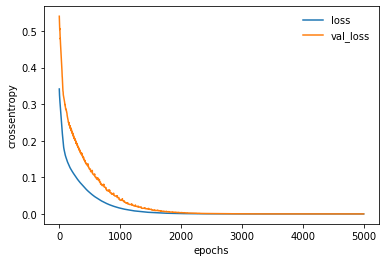

In [28]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False)
plt.xlabel('epochs')
plt.ylabel('crossentropy')
plt.show()

In [29]:
Y_pred = model.predict(X_test)
Y_pred_cls = model.predict_classes(X_test)

In [30]:
Y_pred

array([[0.        ],
       [0.        ],
       [0.9999988 ],
       [0.        ],
       [0.9999988 ],
       [0.        ],
       [0.9999988 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.9999988 ],
       [0.        ],
       [0.        ],
       [0.9999988 ],
       [0.9999988 ],
       [0.        ],
       [0.        ],
       [0.99999666],
       [0.9999988 ],
       [0.        ],
       [0.9999988 ],
       [0.9999103 ],
       [0.        ],
       [0.        ],
       [0.99999714],
       [0.        ],
       [0.        ],
       [0.9999988 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.99999845],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.9999988 ],
       [0.        ],
       [0.9996013 ],
       [0.9999988 ]], dtype=float32)

In [31]:
Y_pred_cls

array([[0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1]], dtype=int32)

In [32]:
Y_pred_ = Y_pred_cls.reshape(-1)

In [33]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred_))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        16

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [34]:
# 目的変数をカテゴリー変数に展開する
dataset2 = pd.get_dummies(data=dataset, columns=['species'])
dataset2.head()

,sepal_length,sepal_width,petal_length,petal_width,is_setosa,species_0,species_1,species_2
0,5.1,3.5,1.4,0.2,1,1,0,0
1,4.9,3.0,1.4,0.2,1,1,0,0
2,4.7,3.2,1.3,0.2,1,1,0,0
3,4.6,3.1,1.5,0.2,1,1,0,0
4,5.0,3.6,1.4,0.2,1,1,0,0


In [35]:
# Y：目的変数、X：説明変数
Y = np.array(dataset2[['species_0', 'species_1', 'species_2']])
X = np.array(dataset2[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])

In [36]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [37]:
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Dense(16, activation='relu', input_shape=(4,)))
# 隠れ層
model.add(Dense(16, activation='relu'))
# 出力層
model.add(Dense(3, activation='softmax'))

# モデルの構築
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 51        
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


In [39]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=5000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=100,
                                                         verbose=1)],
                validation_data=(X_valid, Y_valid))

Train on 94 samples, validate on 11 samples
Epoch 1/5000
94/94 [==============================] - 1s 7ms/sample - loss: 0.9306 - accuracy: 0.3936 - val_loss: 0.9802 - val_accuracy: 0.2727
Epoch 2/5000
94/94 [==============================] - 0s 184us/sample - loss: 0.8948 - accuracy: 0.4681 - val_loss: 0.9257 - val_accuracy: 0.7273
Epoch 3/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.8685 - accuracy: 0.6170 - val_loss: 0.8918 - val_accuracy: 0.9091
Epoch 4/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.8459 - accuracy: 0.6702 - val_loss: 0.8560 - val_accuracy: 0.9091
Epoch 5/5000
94/94 [==============================] - 0s 182us/sample - loss: 0.8292 - accuracy: 0.6702 - val_loss: 0.8286 - val_accuracy: 0.9091
Epoch 6/5000
94/94 [==============================] - 0s 181us/sample - loss: 0.8110 - accuracy: 0.6702 - val_loss: 0.8029 - val_accuracy: 0.9091
Epoch 7/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.79

94/94 [==============================] - 0s 206us/sample - loss: 0.3905 - accuracy: 0.9255 - val_loss: 0.2484 - val_accuracy: 1.0000
Epoch 57/5000
94/94 [==============================] - 0s 184us/sample - loss: 0.3874 - accuracy: 0.9362 - val_loss: 0.2432 - val_accuracy: 1.0000
Epoch 58/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.3795 - accuracy: 0.9149 - val_loss: 0.2421 - val_accuracy: 1.0000
Epoch 59/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.3786 - accuracy: 0.9468 - val_loss: 0.2377 - val_accuracy: 1.0000
Epoch 60/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.3700 - accuracy: 0.9255 - val_loss: 0.2314 - val_accuracy: 1.0000
Epoch 61/5000
94/94 [==============================] - 0s 193us/sample - loss: 0.3682 - accuracy: 0.9149 - val_loss: 0.2271 - val_accuracy: 1.0000
Epoch 62/5000
94/94 [==============================] - 0s 192us/sample - loss: 0.3590 - accuracy: 0.9255 - val_loss: 0.2238 - val_ac

Epoch 112/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.1834 - accuracy: 0.9681 - val_loss: 0.0878 - val_accuracy: 1.0000
Epoch 113/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.1808 - accuracy: 0.9787 - val_loss: 0.0807 - val_accuracy: 1.0000
Epoch 114/5000
94/94 [==============================] - 0s 167us/sample - loss: 0.1793 - accuracy: 0.9787 - val_loss: 0.0796 - val_accuracy: 1.0000
Epoch 115/5000
94/94 [==============================] - 0s 186us/sample - loss: 0.1764 - accuracy: 0.9681 - val_loss: 0.0800 - val_accuracy: 1.0000
Epoch 116/5000
94/94 [==============================] - 0s 199us/sample - loss: 0.1721 - accuracy: 0.9787 - val_loss: 0.0766 - val_accuracy: 1.0000
Epoch 117/5000
94/94 [==============================] - 0s 201us/sample - loss: 0.1718 - accuracy: 0.9681 - val_loss: 0.0744 - val_accuracy: 1.0000
Epoch 118/5000
94/94 [==============================] - 0s 179us/sample - loss: 0.1765 - accuracy: 0.9681 - val_

94/94 [==============================] - 0s 182us/sample - loss: 0.1012 - accuracy: 0.9787 - val_loss: 0.0278 - val_accuracy: 1.0000
Epoch 168/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0982 - accuracy: 0.9787 - val_loss: 0.0256 - val_accuracy: 1.0000
Epoch 169/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0978 - accuracy: 0.9787 - val_loss: 0.0245 - val_accuracy: 1.0000
Epoch 170/5000
94/94 [==============================] - 0s 207us/sample - loss: 0.0969 - accuracy: 0.9787 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 171/5000
94/94 [==============================] - 0s 195us/sample - loss: 0.0951 - accuracy: 0.9787 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 172/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.0961 - accuracy: 0.9787 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 173/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0936 - accuracy: 0.9787 - val_loss: 0.0223 - 

94/94 [==============================] - 0s 177us/sample - loss: 0.0695 - accuracy: 0.9787 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 223/5000
94/94 [==============================] - 0s 194us/sample - loss: 0.0730 - accuracy: 0.9787 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 224/5000
94/94 [==============================] - 0s 204us/sample - loss: 0.0677 - accuracy: 0.9787 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 225/5000
94/94 [==============================] - 0s 202us/sample - loss: 0.0681 - accuracy: 0.9787 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 226/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0754 - accuracy: 0.9787 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 227/5000
94/94 [==============================] - 0s 173us/sample - loss: 0.0700 - accuracy: 0.9787 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 228/5000
94/94 [==============================] - 0s 203us/sample - loss: 0.0710 - accuracy: 0.9787 - val_loss: 0.0089 - 

94/94 [==============================] - 0s 192us/sample - loss: 0.0572 - accuracy: 0.9787 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 278/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0561 - accuracy: 0.9787 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 279/5000
94/94 [==============================] - 0s 199us/sample - loss: 0.0745 - accuracy: 0.9681 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 280/5000
94/94 [==============================] - 0s 206us/sample - loss: 0.0557 - accuracy: 0.9894 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 281/5000
94/94 [==============================] - 0s 197us/sample - loss: 0.0580 - accuracy: 0.9894 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 282/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0567 - accuracy: 0.9787 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 283/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0578 - accuracy: 0.9787 - val_loss: 0.0036 - 

94/94 [==============================] - 0s 189us/sample - loss: 0.0552 - accuracy: 0.9894 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 333/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0502 - accuracy: 0.9787 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 334/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0577 - accuracy: 0.9787 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 335/5000
94/94 [==============================] - 0s 182us/sample - loss: 0.0577 - accuracy: 0.9787 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 336/5000
94/94 [==============================] - 0s 242us/sample - loss: 0.0507 - accuracy: 0.9787 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 337/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0528 - accuracy: 0.9787 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 338/5000
94/94 [==============================] - 0s 196us/sample - loss: 0.0542 - accuracy: 0.9894 - val_loss: 0.0018 - 

94/94 [==============================] - 0s 169us/sample - loss: 0.0481 - accuracy: 0.9894 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 388/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0502 - accuracy: 0.9894 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 389/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0477 - accuracy: 0.9787 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 390/5000
94/94 [==============================] - 0s 177us/sample - loss: 0.0559 - accuracy: 0.9787 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 391/5000
94/94 [==============================] - 0s 173us/sample - loss: 0.0495 - accuracy: 0.9787 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 392/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0463 - accuracy: 0.9787 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 393/5000
94/94 [==============================] - 0s 199us/sample - loss: 0.0488 - accuracy: 0.9787 - val_loss: 0.0016 - 

Epoch 442/5000
94/94 [==============================] - 0s 180us/sample - loss: 0.0460 - accuracy: 0.9894 - val_loss: 7.6995e-04 - val_accuracy: 1.0000
Epoch 443/5000
94/94 [==============================] - 0s 177us/sample - loss: 0.0460 - accuracy: 0.9787 - val_loss: 9.9817e-04 - val_accuracy: 1.0000
Epoch 444/5000
94/94 [==============================] - 0s 184us/sample - loss: 0.0460 - accuracy: 0.9787 - val_loss: 8.5594e-04 - val_accuracy: 1.0000
Epoch 445/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.0557 - accuracy: 0.9787 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 446/5000
94/94 [==============================] - 0s 181us/sample - loss: 0.0473 - accuracy: 0.9894 - val_loss: 9.5497e-04 - val_accuracy: 1.0000
Epoch 447/5000
94/94 [==============================] - 0s 180us/sample - loss: 0.0437 - accuracy: 0.9894 - val_loss: 7.5031e-04 - val_accuracy: 1.0000
Epoch 448/5000
94/94 [==============================] - 0s 194us/sample - loss: 0.0477 - acc

94/94 [==============================] - 0s 178us/sample - loss: 0.0510 - accuracy: 0.9787 - val_loss: 5.0207e-04 - val_accuracy: 1.0000
Epoch 497/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0423 - accuracy: 0.9787 - val_loss: 6.6950e-04 - val_accuracy: 1.0000
Epoch 498/5000
94/94 [==============================] - 0s 177us/sample - loss: 0.0442 - accuracy: 0.9894 - val_loss: 5.1249e-04 - val_accuracy: 1.0000
Epoch 499/5000
94/94 [==============================] - 0s 179us/sample - loss: 0.0424 - accuracy: 0.9787 - val_loss: 7.7932e-04 - val_accuracy: 1.0000
Epoch 500/5000
94/94 [==============================] - 0s 210us/sample - loss: 0.0498 - accuracy: 0.9681 - val_loss: 4.9687e-04 - val_accuracy: 1.0000
Epoch 501/5000
94/94 [==============================] - 0s 181us/sample - loss: 0.0484 - accuracy: 0.9787 - val_loss: 5.4939e-04 - val_accuracy: 1.0000
Epoch 502/5000
94/94 [==============================] - 0s 194us/sample - loss: 0.0458 - accuracy: 0.97

Epoch 550/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0456 - accuracy: 0.9894 - val_loss: 5.4117e-04 - val_accuracy: 1.0000
Epoch 551/5000
94/94 [==============================] - 0s 173us/sample - loss: 0.0502 - accuracy: 0.9787 - val_loss: 6.5741e-04 - val_accuracy: 1.0000
Epoch 552/5000
94/94 [==============================] - 0s 186us/sample - loss: 0.0405 - accuracy: 0.9894 - val_loss: 4.1778e-04 - val_accuracy: 1.0000
Epoch 553/5000
94/94 [==============================] - 0s 181us/sample - loss: 0.0500 - accuracy: 0.9787 - val_loss: 6.2091e-04 - val_accuracy: 1.0000
Epoch 554/5000
94/94 [==============================] - 0s 193us/sample - loss: 0.0419 - accuracy: 0.9787 - val_loss: 5.0897e-04 - val_accuracy: 1.0000
Epoch 555/5000
94/94 [==============================] - 0s 186us/sample - loss: 0.0425 - accuracy: 0.9787 - val_loss: 6.0350e-04 - val_accuracy: 1.0000
Epoch 556/5000
94/94 [==============================] - 0s 194us/sample - loss: 0.0422 -

Epoch 604/5000
94/94 [==============================] - 0s 184us/sample - loss: 0.0494 - accuracy: 0.9787 - val_loss: 4.5816e-04 - val_accuracy: 1.0000
Epoch 605/5000
94/94 [==============================] - 0s 201us/sample - loss: 0.0429 - accuracy: 0.9787 - val_loss: 3.7592e-04 - val_accuracy: 1.0000
Epoch 606/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0403 - accuracy: 0.9894 - val_loss: 2.9712e-04 - val_accuracy: 1.0000
Epoch 607/5000
94/94 [==============================] - 0s 193us/sample - loss: 0.0431 - accuracy: 0.9787 - val_loss: 2.6253e-04 - val_accuracy: 1.0000
Epoch 608/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0393 - accuracy: 0.9787 - val_loss: 3.4127e-04 - val_accuracy: 1.0000
Epoch 609/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0399 - accuracy: 0.9787 - val_loss: 3.7682e-04 - val_accuracy: 1.0000
Epoch 610/5000
94/94 [==============================] - 0s 181us/sample - loss: 0.0397 -

Epoch 658/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0396 - accuracy: 0.9787 - val_loss: 2.0872e-04 - val_accuracy: 1.0000
Epoch 659/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0384 - accuracy: 0.9787 - val_loss: 3.6337e-04 - val_accuracy: 1.0000
Epoch 660/5000
94/94 [==============================] - 0s 176us/sample - loss: 0.0385 - accuracy: 0.9894 - val_loss: 3.0640e-04 - val_accuracy: 1.0000
Epoch 661/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0383 - accuracy: 0.9787 - val_loss: 3.2579e-04 - val_accuracy: 1.0000
Epoch 662/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0395 - accuracy: 0.9787 - val_loss: 2.8032e-04 - val_accuracy: 1.0000
Epoch 663/5000
94/94 [==============================] - 0s 163us/sample - loss: 0.0394 - accuracy: 0.9894 - val_loss: 4.5683e-04 - val_accuracy: 1.0000
Epoch 664/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0465 -

Epoch 712/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0379 - accuracy: 0.9894 - val_loss: 2.2390e-04 - val_accuracy: 1.0000
Epoch 713/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0433 - accuracy: 0.9894 - val_loss: 1.5942e-04 - val_accuracy: 1.0000
Epoch 714/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0445 - accuracy: 0.9787 - val_loss: 2.8165e-04 - val_accuracy: 1.0000
Epoch 715/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0410 - accuracy: 0.9894 - val_loss: 2.5743e-04 - val_accuracy: 1.0000
Epoch 716/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0415 - accuracy: 0.9894 - val_loss: 2.0167e-04 - val_accuracy: 1.0000
Epoch 717/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0373 - accuracy: 0.9787 - val_loss: 1.9396e-04 - val_accuracy: 1.0000
Epoch 718/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0379 -

Epoch 766/5000
94/94 [==============================] - 0s 208us/sample - loss: 0.0400 - accuracy: 0.9787 - val_loss: 1.3604e-04 - val_accuracy: 1.0000
Epoch 767/5000
94/94 [==============================] - 0s 193us/sample - loss: 0.0458 - accuracy: 0.9787 - val_loss: 2.2011e-04 - val_accuracy: 1.0000
Epoch 768/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.0363 - accuracy: 0.9894 - val_loss: 1.4530e-04 - val_accuracy: 1.0000
Epoch 769/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0398 - accuracy: 0.9787 - val_loss: 2.0139e-04 - val_accuracy: 1.0000
Epoch 770/5000
94/94 [==============================] - 0s 191us/sample - loss: 0.0362 - accuracy: 0.9894 - val_loss: 1.4733e-04 - val_accuracy: 1.0000
Epoch 771/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0383 - accuracy: 0.9894 - val_loss: 1.9134e-04 - val_accuracy: 1.0000
Epoch 772/5000
94/94 [==============================] - 0s 193us/sample - loss: 0.0440 -

Epoch 820/5000
94/94 [==============================] - 0s 202us/sample - loss: 0.0373 - accuracy: 0.9894 - val_loss: 1.3530e-04 - val_accuracy: 1.0000
Epoch 821/5000
94/94 [==============================] - 0s 163us/sample - loss: 0.0445 - accuracy: 0.9787 - val_loss: 2.0812e-04 - val_accuracy: 1.0000
Epoch 822/5000
94/94 [==============================] - 0s 184us/sample - loss: 0.0364 - accuracy: 0.9894 - val_loss: 1.4690e-04 - val_accuracy: 1.0000
Epoch 823/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0359 - accuracy: 0.9787 - val_loss: 1.8767e-04 - val_accuracy: 1.0000
Epoch 824/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0421 - accuracy: 0.9894 - val_loss: 1.0299e-04 - val_accuracy: 1.0000
Epoch 825/5000
94/94 [==============================] - 0s 197us/sample - loss: 0.0359 - accuracy: 0.9787 - val_loss: 1.3621e-04 - val_accuracy: 1.0000
Epoch 826/5000
94/94 [==============================] - 0s 195us/sample - loss: 0.0396 -

Epoch 874/5000
94/94 [==============================] - 0s 192us/sample - loss: 0.0362 - accuracy: 0.9894 - val_loss: 1.4529e-04 - val_accuracy: 1.0000
Epoch 875/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0370 - accuracy: 0.9894 - val_loss: 1.0217e-04 - val_accuracy: 1.0000
Epoch 876/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0458 - accuracy: 0.9787 - val_loss: 7.4305e-05 - val_accuracy: 1.0000
Epoch 877/5000
94/94 [==============================] - 0s 182us/sample - loss: 0.0392 - accuracy: 0.9787 - val_loss: 1.3905e-04 - val_accuracy: 1.0000
Epoch 878/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0378 - accuracy: 0.9894 - val_loss: 9.0361e-05 - val_accuracy: 1.0000
Epoch 879/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0361 - accuracy: 0.9894 - val_loss: 8.8465e-05 - val_accuracy: 1.0000
Epoch 880/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0345 -

Epoch 928/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0344 - accuracy: 0.9894 - val_loss: 8.3317e-05 - val_accuracy: 1.0000
Epoch 929/5000
94/94 [==============================] - 0s 191us/sample - loss: 0.0369 - accuracy: 0.9787 - val_loss: 7.8930e-05 - val_accuracy: 1.0000
Epoch 930/5000
94/94 [==============================] - 0s 196us/sample - loss: 0.0384 - accuracy: 0.9894 - val_loss: 7.0252e-05 - val_accuracy: 1.0000
Epoch 931/5000
94/94 [==============================] - 0s 196us/sample - loss: 0.0373 - accuracy: 0.9787 - val_loss: 1.2135e-04 - val_accuracy: 1.0000
Epoch 932/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0374 - accuracy: 0.9787 - val_loss: 6.3708e-05 - val_accuracy: 1.0000
Epoch 933/5000
94/94 [==============================] - 0s 199us/sample - loss: 0.0362 - accuracy: 0.9787 - val_loss: 8.5831e-05 - val_accuracy: 1.0000
Epoch 934/5000
94/94 [==============================] - 0s 200us/sample - loss: 0.0352 -

Epoch 982/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.0364 - accuracy: 0.9787 - val_loss: 8.0152e-05 - val_accuracy: 1.0000
Epoch 983/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0352 - accuracy: 0.9894 - val_loss: 5.7173e-05 - val_accuracy: 1.0000
Epoch 984/5000
94/94 [==============================] - 0s 182us/sample - loss: 0.0336 - accuracy: 0.9787 - val_loss: 1.0157e-04 - val_accuracy: 1.0000
Epoch 985/5000
94/94 [==============================] - 0s 184us/sample - loss: 0.0401 - accuracy: 0.9787 - val_loss: 5.5613e-05 - val_accuracy: 1.0000
Epoch 986/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.0350 - accuracy: 0.9787 - val_loss: 6.4898e-05 - val_accuracy: 1.0000
Epoch 987/5000
94/94 [==============================] - 0s 186us/sample - loss: 0.0410 - accuracy: 0.9787 - val_loss: 8.1756e-05 - val_accuracy: 1.0000
Epoch 988/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0352 -

Epoch 1036/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0353 - accuracy: 1.0000 - val_loss: 5.6078e-05 - val_accuracy: 1.0000
Epoch 1037/5000
94/94 [==============================] - 0s 182us/sample - loss: 0.0452 - accuracy: 0.9787 - val_loss: 5.5775e-05 - val_accuracy: 1.0000
Epoch 1038/5000
94/94 [==============================] - 0s 181us/sample - loss: 0.0338 - accuracy: 0.9787 - val_loss: 7.3347e-05 - val_accuracy: 1.0000
Epoch 1039/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0383 - accuracy: 0.9787 - val_loss: 1.0232e-04 - val_accuracy: 1.0000
Epoch 1040/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0333 - accuracy: 0.9894 - val_loss: 5.9686e-05 - val_accuracy: 1.0000
Epoch 1041/5000
94/94 [==============================] - 0s 204us/sample - loss: 0.0327 - accuracy: 0.9787 - val_loss: 7.7919e-05 - val_accuracy: 1.0000
Epoch 1042/5000
94/94 [==============================] - 0s 186us/sample - loss: 0

94/94 [==============================] - 0s 167us/sample - loss: 0.0338 - accuracy: 0.9894 - val_loss: 3.9944e-05 - val_accuracy: 1.0000
Epoch 1090/5000
94/94 [==============================] - 0s 177us/sample - loss: 0.0353 - accuracy: 0.9787 - val_loss: 8.3865e-05 - val_accuracy: 1.0000
Epoch 1091/5000
94/94 [==============================] - 0s 180us/sample - loss: 0.0335 - accuracy: 0.9894 - val_loss: 6.4030e-05 - val_accuracy: 1.0000
Epoch 1092/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0409 - accuracy: 0.9787 - val_loss: 9.6290e-05 - val_accuracy: 1.0000
Epoch 1093/5000
94/94 [==============================] - 0s 163us/sample - loss: 0.0333 - accuracy: 0.9894 - val_loss: 4.8200e-05 - val_accuracy: 1.0000
Epoch 1094/5000
94/94 [==============================] - 0s 164us/sample - loss: 0.0334 - accuracy: 0.9894 - val_loss: 7.0811e-05 - val_accuracy: 1.0000
Epoch 1095/5000
94/94 [==============================] - 0s 164us/sample - loss: 0.0368 - accuracy

Epoch 1143/5000
94/94 [==============================] - 0s 162us/sample - loss: 0.0514 - accuracy: 0.9681 - val_loss: 3.3984e-05 - val_accuracy: 1.0000
Epoch 1144/5000
94/94 [==============================] - 0s 158us/sample - loss: 0.0400 - accuracy: 0.9787 - val_loss: 3.9835e-05 - val_accuracy: 1.0000
Epoch 1145/5000
94/94 [==============================] - 0s 157us/sample - loss: 0.0422 - accuracy: 0.9787 - val_loss: 3.4970e-05 - val_accuracy: 1.0000
Epoch 1146/5000
94/94 [==============================] - 0s 162us/sample - loss: 0.0402 - accuracy: 0.9787 - val_loss: 3.4515e-05 - val_accuracy: 1.0000
Epoch 1147/5000
94/94 [==============================] - 0s 162us/sample - loss: 0.0375 - accuracy: 0.9787 - val_loss: 3.9283e-05 - val_accuracy: 1.0000
Epoch 1148/5000
94/94 [==============================] - 0s 233us/sample - loss: 0.0374 - accuracy: 0.9787 - val_loss: 3.6509e-05 - val_accuracy: 1.0000
Epoch 1149/5000
94/94 [==============================] - 0s 240us/sample - loss: 0

94/94 [==============================] - 0s 158us/sample - loss: 0.0332 - accuracy: 0.9894 - val_loss: 3.3854e-05 - val_accuracy: 1.0000
Epoch 1197/5000
94/94 [==============================] - 0s 160us/sample - loss: 0.0321 - accuracy: 0.9787 - val_loss: 3.1286e-05 - val_accuracy: 1.0000
Epoch 1198/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0314 - accuracy: 0.9787 - val_loss: 3.8253e-05 - val_accuracy: 1.0000
Epoch 1199/5000
94/94 [==============================] - 0s 173us/sample - loss: 0.0331 - accuracy: 0.9894 - val_loss: 4.5296e-05 - val_accuracy: 1.0000
Epoch 1200/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0350 - accuracy: 0.9894 - val_loss: 4.2479e-05 - val_accuracy: 1.0000
Epoch 1201/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0316 - accuracy: 0.9787 - val_loss: 4.5068e-05 - val_accuracy: 1.0000
Epoch 1202/5000
94/94 [==============================] - 0s 167us/sample - loss: 0.0431 - accuracy

Epoch 1250/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0330 - accuracy: 0.9787 - val_loss: 2.9259e-05 - val_accuracy: 1.0000
Epoch 1251/5000
94/94 [==============================] - 0s 179us/sample - loss: 0.0351 - accuracy: 0.9894 - val_loss: 2.0070e-05 - val_accuracy: 1.0000
Epoch 1252/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0386 - accuracy: 0.9787 - val_loss: 3.9434e-05 - val_accuracy: 1.0000
Epoch 1253/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0321 - accuracy: 0.9894 - val_loss: 4.1644e-05 - val_accuracy: 1.0000
Epoch 1254/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0303 - accuracy: 0.9894 - val_loss: 2.4600e-05 - val_accuracy: 1.0000
Epoch 1255/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0332 - accuracy: 0.9894 - val_loss: 3.8924e-05 - val_accuracy: 1.0000
Epoch 1256/5000
94/94 [==============================] - 0s 169us/sample - loss: 0

94/94 [==============================] - 0s 161us/sample - loss: 0.0343 - accuracy: 0.9787 - val_loss: 2.9595e-05 - val_accuracy: 1.0000
Epoch 1304/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0329 - accuracy: 0.9787 - val_loss: 4.1687e-05 - val_accuracy: 1.0000
Epoch 1305/5000
94/94 [==============================] - 0s 160us/sample - loss: 0.0303 - accuracy: 1.0000 - val_loss: 2.0894e-05 - val_accuracy: 1.0000
Epoch 1306/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0377 - accuracy: 0.9894 - val_loss: 1.7209e-05 - val_accuracy: 1.0000
Epoch 1307/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0332 - accuracy: 0.9787 - val_loss: 3.5728e-05 - val_accuracy: 1.0000
Epoch 1308/5000
94/94 [==============================] - 0s 163us/sample - loss: 0.0304 - accuracy: 1.0000 - val_loss: 2.3321e-05 - val_accuracy: 1.0000
Epoch 1309/5000
94/94 [==============================] - 0s 163us/sample - loss: 0.0310 - accuracy

Epoch 1357/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0353 - accuracy: 0.9894 - val_loss: 1.7383e-05 - val_accuracy: 1.0000
Epoch 1358/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0340 - accuracy: 0.9787 - val_loss: 3.1209e-05 - val_accuracy: 1.0000
Epoch 1359/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0315 - accuracy: 1.0000 - val_loss: 1.8314e-05 - val_accuracy: 1.0000
Epoch 1360/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0333 - accuracy: 0.9787 - val_loss: 1.6949e-05 - val_accuracy: 1.0000
Epoch 1361/5000
94/94 [==============================] - 0s 163us/sample - loss: 0.0328 - accuracy: 0.9787 - val_loss: 2.1338e-05 - val_accuracy: 1.0000
Epoch 1362/5000
94/94 [==============================] - 0s 167us/sample - loss: 0.0305 - accuracy: 0.9894 - val_loss: 3.2618e-05 - val_accuracy: 1.0000
Epoch 1363/5000
94/94 [==============================] - 0s 166us/sample - loss: 0

94/94 [==============================] - 0s 186us/sample - loss: 0.0304 - accuracy: 0.9787 - val_loss: 4.0181e-05 - val_accuracy: 1.0000
Epoch 1411/5000
94/94 [==============================] - 0s 163us/sample - loss: 0.0299 - accuracy: 1.0000 - val_loss: 1.4641e-05 - val_accuracy: 1.0000
Epoch 1412/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0308 - accuracy: 0.9894 - val_loss: 1.8098e-05 - val_accuracy: 1.0000
Epoch 1413/5000
94/94 [==============================] - 0s 164us/sample - loss: 0.0363 - accuracy: 0.9681 - val_loss: 1.6797e-05 - val_accuracy: 1.0000
Epoch 1414/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0319 - accuracy: 0.9894 - val_loss: 1.3991e-05 - val_accuracy: 1.0000
Epoch 1415/5000
94/94 [==============================] - 0s 181us/sample - loss: 0.0315 - accuracy: 0.9787 - val_loss: 2.7157e-05 - val_accuracy: 1.0000
Epoch 1416/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0365 - accuracy

Epoch 1464/5000
94/94 [==============================] - 0s 163us/sample - loss: 0.0305 - accuracy: 0.9787 - val_loss: 2.9074e-05 - val_accuracy: 1.0000
Epoch 1465/5000
94/94 [==============================] - 0s 160us/sample - loss: 0.0285 - accuracy: 1.0000 - val_loss: 1.3416e-05 - val_accuracy: 1.0000
Epoch 1466/5000
94/94 [==============================] - 0s 160us/sample - loss: 0.0327 - accuracy: 0.9894 - val_loss: 1.1812e-05 - val_accuracy: 1.0000
Epoch 1467/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0312 - accuracy: 0.9894 - val_loss: 1.5421e-05 - val_accuracy: 1.0000
Epoch 1468/5000
94/94 [==============================] - 0s 156us/sample - loss: 0.0315 - accuracy: 0.9787 - val_loss: 2.6615e-05 - val_accuracy: 1.0000
Epoch 1469/5000
94/94 [==============================] - 0s 184us/sample - loss: 0.0293 - accuracy: 1.0000 - val_loss: 1.1010e-05 - val_accuracy: 1.0000
Epoch 1470/5000
94/94 [==============================] - 0s 185us/sample - loss: 0

94/94 [==============================] - 0s 164us/sample - loss: 0.0361 - accuracy: 0.9787 - val_loss: 1.7404e-05 - val_accuracy: 1.0000
Epoch 1518/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0295 - accuracy: 1.0000 - val_loss: 1.3525e-05 - val_accuracy: 1.0000
Epoch 1519/5000
94/94 [==============================] - 0s 164us/sample - loss: 0.0396 - accuracy: 0.9787 - val_loss: 1.2950e-05 - val_accuracy: 1.0000
Epoch 1520/5000
94/94 [==============================] - 0s 180us/sample - loss: 0.0336 - accuracy: 0.9787 - val_loss: 1.2831e-05 - val_accuracy: 1.0000
Epoch 1521/5000
94/94 [==============================] - 0s 163us/sample - loss: 0.0381 - accuracy: 0.9787 - val_loss: 1.0675e-05 - val_accuracy: 1.0000
Epoch 1522/5000
94/94 [==============================] - 0s 178us/sample - loss: 0.0319 - accuracy: 0.9894 - val_loss: 1.4186e-05 - val_accuracy: 1.0000
Epoch 1523/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0290 - accuracy

Epoch 1571/5000
94/94 [==============================] - 0s 179us/sample - loss: 0.0283 - accuracy: 1.0000 - val_loss: 1.3048e-05 - val_accuracy: 1.0000
Epoch 1572/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0430 - accuracy: 0.9787 - val_loss: 2.1641e-05 - val_accuracy: 1.0000
Epoch 1573/5000
94/94 [==============================] - 0s 178us/sample - loss: 0.0439 - accuracy: 0.9787 - val_loss: 1.8672e-05 - val_accuracy: 1.0000
Epoch 1574/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0398 - accuracy: 0.9681 - val_loss: 1.1899e-05 - val_accuracy: 1.0000
Epoch 1575/5000
94/94 [==============================] - 0s 175us/sample - loss: 0.0286 - accuracy: 0.9787 - val_loss: 1.1650e-05 - val_accuracy: 1.0000
Epoch 1576/5000
94/94 [==============================] - 0s 173us/sample - loss: 0.0290 - accuracy: 0.9894 - val_loss: 1.1075e-05 - val_accuracy: 1.0000
Epoch 1577/5000
94/94 [==============================] - 0s 175us/sample - loss: 0

94/94 [==============================] - 0s 176us/sample - loss: 0.0398 - accuracy: 0.9787 - val_loss: 2.1652e-05 - val_accuracy: 1.0000
Epoch 1625/5000
94/94 [==============================] - 0s 195us/sample - loss: 0.0338 - accuracy: 0.9894 - val_loss: 1.3633e-05 - val_accuracy: 1.0000
Epoch 1626/5000
94/94 [==============================] - 0s 194us/sample - loss: 0.0291 - accuracy: 1.0000 - val_loss: 1.1368e-05 - val_accuracy: 1.0000
Epoch 1627/5000
94/94 [==============================] - 0s 213us/sample - loss: 0.0290 - accuracy: 1.0000 - val_loss: 8.9189e-06 - val_accuracy: 1.0000
Epoch 1628/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0286 - accuracy: 0.9894 - val_loss: 1.0729e-05 - val_accuracy: 1.0000
Epoch 1629/5000
94/94 [==============================] - 0s 207us/sample - loss: 0.0286 - accuracy: 0.9787 - val_loss: 1.8292e-05 - val_accuracy: 1.0000
Epoch 1630/5000
94/94 [==============================] - 0s 182us/sample - loss: 0.0394 - accuracy

Epoch 1678/5000
94/94 [==============================] - 0s 192us/sample - loss: 0.0292 - accuracy: 0.9894 - val_loss: 1.1195e-05 - val_accuracy: 1.0000
Epoch 1679/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0275 - accuracy: 0.9894 - val_loss: 9.1790e-06 - val_accuracy: 1.0000
Epoch 1680/5000
94/94 [==============================] - 0s 184us/sample - loss: 0.0284 - accuracy: 0.9894 - val_loss: 1.0003e-05 - val_accuracy: 1.0000
Epoch 1681/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0325 - accuracy: 0.9787 - val_loss: 1.6212e-05 - val_accuracy: 1.0000
Epoch 1682/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0301 - accuracy: 0.9894 - val_loss: 9.8509e-06 - val_accuracy: 1.0000
Epoch 1683/5000
94/94 [==============================] - 0s 191us/sample - loss: 0.0301 - accuracy: 0.9787 - val_loss: 1.2018e-05 - val_accuracy: 1.0000
Epoch 1684/5000
94/94 [==============================] - 0s 197us/sample - loss: 0

94/94 [==============================] - 0s 193us/sample - loss: 0.0278 - accuracy: 0.9894 - val_loss: 1.2029e-05 - val_accuracy: 1.0000
Epoch 1732/5000
94/94 [==============================] - 0s 198us/sample - loss: 0.0312 - accuracy: 1.0000 - val_loss: 6.4698e-06 - val_accuracy: 1.0000
Epoch 1733/5000
94/94 [==============================] - 0s 173us/sample - loss: 0.0346 - accuracy: 0.9787 - val_loss: 1.5746e-05 - val_accuracy: 1.0000
Epoch 1734/5000
94/94 [==============================] - 0s 195us/sample - loss: 0.0333 - accuracy: 0.9787 - val_loss: 1.1162e-05 - val_accuracy: 1.0000
Epoch 1735/5000
94/94 [==============================] - 0s 175us/sample - loss: 0.0270 - accuracy: 0.9894 - val_loss: 8.8430e-06 - val_accuracy: 1.0000
Epoch 1736/5000
94/94 [==============================] - 0s 210us/sample - loss: 0.0306 - accuracy: 0.9787 - val_loss: 1.7794e-05 - val_accuracy: 1.0000
Epoch 1737/5000
94/94 [==============================] - 0s 199us/sample - loss: 0.0274 - accuracy

Epoch 1785/5000
94/94 [==============================] - 0s 178us/sample - loss: 0.0385 - accuracy: 0.9787 - val_loss: 1.4023e-05 - val_accuracy: 1.0000
Epoch 1786/5000
94/94 [==============================] - 0s 201us/sample - loss: 0.0302 - accuracy: 1.0000 - val_loss: 5.8520e-06 - val_accuracy: 1.0000
Epoch 1787/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0412 - accuracy: 0.9787 - val_loss: 5.9279e-06 - val_accuracy: 1.0000
Epoch 1788/5000
94/94 [==============================] - 0s 178us/sample - loss: 0.0343 - accuracy: 0.9787 - val_loss: 7.5534e-06 - val_accuracy: 1.0000
Epoch 1789/5000
94/94 [==============================] - 0s 179us/sample - loss: 0.0307 - accuracy: 0.9787 - val_loss: 1.2419e-05 - val_accuracy: 1.0000
Epoch 1790/5000
94/94 [==============================] - 0s 195us/sample - loss: 0.0285 - accuracy: 0.9894 - val_loss: 5.8954e-06 - val_accuracy: 1.0000
Epoch 1791/5000
94/94 [==============================] - 0s 198us/sample - loss: 0

94/94 [==============================] - 0s 187us/sample - loss: 0.0350 - accuracy: 0.9681 - val_loss: 5.6136e-06 - val_accuracy: 1.0000
Epoch 1839/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0280 - accuracy: 0.9787 - val_loss: 9.0706e-06 - val_accuracy: 1.0000
Epoch 1840/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0316 - accuracy: 0.9894 - val_loss: 8.1495e-06 - val_accuracy: 1.0000
Epoch 1841/5000
94/94 [==============================] - 0s 186us/sample - loss: 0.0305 - accuracy: 0.9894 - val_loss: 5.3969e-06 - val_accuracy: 1.0000
Epoch 1842/5000
94/94 [==============================] - 0s 182us/sample - loss: 0.0291 - accuracy: 0.9787 - val_loss: 7.8569e-06 - val_accuracy: 1.0000
Epoch 1843/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0281 - accuracy: 1.0000 - val_loss: 4.3132e-06 - val_accuracy: 1.0000
Epoch 1844/5000
94/94 [==============================] - 0s 186us/sample - loss: 0.0305 - accuracy

Epoch 1892/5000
94/94 [==============================] - 0s 184us/sample - loss: 0.0368 - accuracy: 0.9787 - val_loss: 4.4107e-06 - val_accuracy: 1.0000
Epoch 1893/5000
94/94 [==============================] - 0s 162us/sample - loss: 0.0332 - accuracy: 0.9787 - val_loss: 4.8442e-06 - val_accuracy: 1.0000
Epoch 1894/5000
94/94 [==============================] - 0s 199us/sample - loss: 0.0279 - accuracy: 0.9787 - val_loss: 5.6678e-06 - val_accuracy: 1.0000
Epoch 1895/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0282 - accuracy: 0.9894 - val_loss: 5.3535e-06 - val_accuracy: 1.0000
Epoch 1896/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0294 - accuracy: 0.9787 - val_loss: 1.0490e-05 - val_accuracy: 1.0000
Epoch 1897/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0272 - accuracy: 0.9894 - val_loss: 4.0964e-06 - val_accuracy: 1.0000
Epoch 1898/5000
94/94 [==============================] - 0s 164us/sample - loss: 0

94/94 [==============================] - 0s 174us/sample - loss: 0.0345 - accuracy: 0.9787 - val_loss: 3.4787e-06 - val_accuracy: 1.0000
Epoch 1946/5000
94/94 [==============================] - 0s 175us/sample - loss: 0.0302 - accuracy: 0.9787 - val_loss: 6.3072e-06 - val_accuracy: 1.0000
Epoch 1947/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0352 - accuracy: 0.9787 - val_loss: 3.9556e-06 - val_accuracy: 1.0000
Epoch 1948/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0359 - accuracy: 0.9681 - val_loss: 4.1831e-06 - val_accuracy: 1.0000
Epoch 1949/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0354 - accuracy: 0.9787 - val_loss: 3.5546e-06 - val_accuracy: 1.0000
Epoch 1950/5000
94/94 [==============================] - 0s 197us/sample - loss: 0.0279 - accuracy: 0.9894 - val_loss: 6.2747e-06 - val_accuracy: 1.0000
Epoch 1951/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0308 - accuracy

Epoch 1999/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0308 - accuracy: 0.9894 - val_loss: 3.0561e-06 - val_accuracy: 1.0000
Epoch 2000/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0351 - accuracy: 0.9787 - val_loss: 7.4234e-06 - val_accuracy: 1.0000
Epoch 2001/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.0357 - accuracy: 0.9787 - val_loss: 4.7141e-06 - val_accuracy: 1.0000
Epoch 2002/5000
94/94 [==============================] - 0s 195us/sample - loss: 0.0266 - accuracy: 0.9894 - val_loss: 5.4727e-06 - val_accuracy: 1.0000
Epoch 2003/5000
94/94 [==============================] - 0s 199us/sample - loss: 0.0299 - accuracy: 0.9894 - val_loss: 3.1428e-06 - val_accuracy: 1.0000
Epoch 2004/5000
94/94 [==============================] - 0s 193us/sample - loss: 0.0278 - accuracy: 0.9787 - val_loss: 6.9899e-06 - val_accuracy: 1.0000
Epoch 2005/5000
94/94 [==============================] - 0s 195us/sample - loss: 0

94/94 [==============================] - 0s 176us/sample - loss: 0.0271 - accuracy: 0.9894 - val_loss: 4.8442e-06 - val_accuracy: 1.0000
Epoch 2053/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0297 - accuracy: 0.9787 - val_loss: 7.4234e-06 - val_accuracy: 1.0000
Epoch 2054/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0417 - accuracy: 0.9787 - val_loss: 2.9694e-06 - val_accuracy: 1.0000
Epoch 2055/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0275 - accuracy: 0.9894 - val_loss: 4.6816e-06 - val_accuracy: 1.0000
Epoch 2056/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0276 - accuracy: 1.0000 - val_loss: 3.1319e-06 - val_accuracy: 1.0000
Epoch 2057/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0293 - accuracy: 0.9787 - val_loss: 6.0037e-06 - val_accuracy: 1.0000
Epoch 2058/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0282 - accuracy

Epoch 2106/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0351 - accuracy: 0.9787 - val_loss: 6.3722e-06 - val_accuracy: 1.0000
Epoch 2107/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0284 - accuracy: 0.9894 - val_loss: 4.8333e-06 - val_accuracy: 1.0000
Epoch 2108/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0300 - accuracy: 0.9787 - val_loss: 3.4896e-06 - val_accuracy: 1.0000
Epoch 2109/5000
94/94 [==============================] - 0s 175us/sample - loss: 0.0265 - accuracy: 0.9894 - val_loss: 4.2373e-06 - val_accuracy: 1.0000
Epoch 2110/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0295 - accuracy: 1.0000 - val_loss: 2.9585e-06 - val_accuracy: 1.0000
Epoch 2111/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0341 - accuracy: 0.9787 - val_loss: 2.8502e-06 - val_accuracy: 1.0000
Epoch 2112/5000
94/94 [==============================] - 0s 163us/sample - loss: 0

94/94 [==============================] - 0s 178us/sample - loss: 0.0536 - accuracy: 0.9574 - val_loss: 2.4709e-06 - val_accuracy: 1.0000
Epoch 2160/5000
94/94 [==============================] - 0s 175us/sample - loss: 0.0340 - accuracy: 0.9787 - val_loss: 2.8502e-06 - val_accuracy: 1.0000
Epoch 2161/5000
94/94 [==============================] - 0s 167us/sample - loss: 0.0287 - accuracy: 0.9787 - val_loss: 3.4245e-06 - val_accuracy: 1.0000
Epoch 2162/5000
94/94 [==============================] - 0s 160us/sample - loss: 0.0288 - accuracy: 1.0000 - val_loss: 2.4167e-06 - val_accuracy: 1.0000
Epoch 2163/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0298 - accuracy: 0.9894 - val_loss: 2.6443e-06 - val_accuracy: 1.0000
Epoch 2164/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0278 - accuracy: 0.9894 - val_loss: 3.2078e-06 - val_accuracy: 1.0000
Epoch 2165/5000
94/94 [==============================] - 0s 164us/sample - loss: 0.0344 - accuracy

Epoch 2213/5000
94/94 [==============================] - 0s 179us/sample - loss: 0.0300 - accuracy: 0.9894 - val_loss: 2.4275e-06 - val_accuracy: 1.0000
Epoch 2214/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0300 - accuracy: 0.9894 - val_loss: 3.8363e-06 - val_accuracy: 1.0000
Epoch 2215/5000
94/94 [==============================] - 0s 167us/sample - loss: 0.0264 - accuracy: 1.0000 - val_loss: 2.3733e-06 - val_accuracy: 1.0000
Epoch 2216/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0383 - accuracy: 0.9787 - val_loss: 3.6955e-06 - val_accuracy: 1.0000
Epoch 2217/5000
94/94 [==============================] - 0s 180us/sample - loss: 0.0291 - accuracy: 0.9894 - val_loss: 3.7822e-06 - val_accuracy: 1.0000
Epoch 2218/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0251 - accuracy: 1.0000 - val_loss: 2.5034e-06 - val_accuracy: 1.0000
Epoch 2219/5000
94/94 [==============================] - 0s 163us/sample - loss: 0

94/94 [==============================] - 0s 162us/sample - loss: 0.0329 - accuracy: 0.9894 - val_loss: 4.1181e-06 - val_accuracy: 1.0000
Epoch 2267/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0357 - accuracy: 0.9894 - val_loss: 3.0886e-06 - val_accuracy: 1.0000
Epoch 2268/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0267 - accuracy: 0.9894 - val_loss: 3.3704e-06 - val_accuracy: 1.0000
Epoch 2269/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0300 - accuracy: 0.9894 - val_loss: 3.5329e-06 - val_accuracy: 1.0000
Epoch 2270/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0249 - accuracy: 1.0000 - val_loss: 2.9802e-06 - val_accuracy: 1.0000
Epoch 2271/5000
94/94 [==============================] - 0s 173us/sample - loss: 0.0251 - accuracy: 1.0000 - val_loss: 2.1458e-06 - val_accuracy: 1.0000
Epoch 2272/5000
94/94 [==============================] - 0s 181us/sample - loss: 0.0300 - accuracy

Epoch 2320/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0339 - accuracy: 0.9787 - val_loss: 1.9290e-06 - val_accuracy: 1.0000
Epoch 2321/5000
94/94 [==============================] - 0s 192us/sample - loss: 0.0259 - accuracy: 0.9787 - val_loss: 3.2837e-06 - val_accuracy: 1.0000
Epoch 2322/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0245 - accuracy: 1.0000 - val_loss: 2.0916e-06 - val_accuracy: 1.0000
Epoch 2323/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0381 - accuracy: 0.9787 - val_loss: 2.5251e-06 - val_accuracy: 1.0000
Epoch 2324/5000
94/94 [==============================] - 0s 176us/sample - loss: 0.0242 - accuracy: 1.0000 - val_loss: 2.5142e-06 - val_accuracy: 1.0000
Epoch 2325/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0279 - accuracy: 0.9787 - val_loss: 2.2216e-06 - val_accuracy: 1.0000
Epoch 2326/5000
94/94 [==============================] - 0s 167us/sample - loss: 0

94/94 [==============================] - 0s 165us/sample - loss: 0.0252 - accuracy: 0.9894 - val_loss: 2.2650e-06 - val_accuracy: 1.0000
Epoch 2374/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0259 - accuracy: 1.0000 - val_loss: 1.8640e-06 - val_accuracy: 1.0000
Epoch 2375/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0256 - accuracy: 0.9894 - val_loss: 2.1783e-06 - val_accuracy: 1.0000
Epoch 2376/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0284 - accuracy: 0.9787 - val_loss: 2.4275e-06 - val_accuracy: 1.0000
Epoch 2377/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0371 - accuracy: 0.9787 - val_loss: 4.0748e-06 - val_accuracy: 1.0000
Epoch 2378/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0333 - accuracy: 0.9681 - val_loss: 2.4925e-06 - val_accuracy: 1.0000
Epoch 2379/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0263 - accuracy

Epoch 2427/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0249 - accuracy: 0.9894 - val_loss: 2.2108e-06 - val_accuracy: 1.0000
Epoch 2428/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0277 - accuracy: 1.0000 - val_loss: 1.9290e-06 - val_accuracy: 1.0000
Epoch 2429/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0377 - accuracy: 0.9787 - val_loss: 3.8797e-06 - val_accuracy: 1.0000
Epoch 2430/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0368 - accuracy: 0.9787 - val_loss: 1.6256e-06 - val_accuracy: 1.0000
Epoch 2431/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0282 - accuracy: 0.9787 - val_loss: 2.5142e-06 - val_accuracy: 1.0000
Epoch 2432/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0255 - accuracy: 0.9894 - val_loss: 2.5792e-06 - val_accuracy: 1.0000
Epoch 2433/5000
94/94 [==============================] - 0s 173us/sample - loss: 0

94/94 [==============================] - 0s 163us/sample - loss: 0.0258 - accuracy: 0.9894 - val_loss: 1.7773e-06 - val_accuracy: 1.0000
Epoch 2481/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0243 - accuracy: 0.9894 - val_loss: 2.0374e-06 - val_accuracy: 1.0000
Epoch 2482/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0305 - accuracy: 0.9894 - val_loss: 1.6364e-06 - val_accuracy: 1.0000
Epoch 2483/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0258 - accuracy: 0.9894 - val_loss: 1.9182e-06 - val_accuracy: 1.0000
Epoch 2484/5000
94/94 [==============================] - 0s 162us/sample - loss: 0.0308 - accuracy: 0.9894 - val_loss: 2.2866e-06 - val_accuracy: 1.0000
Epoch 2485/5000
94/94 [==============================] - 0s 162us/sample - loss: 0.0292 - accuracy: 0.9894 - val_loss: 2.1674e-06 - val_accuracy: 1.0000
Epoch 2486/5000
94/94 [==============================] - 0s 189us/sample - loss: 0.0430 - accuracy

Epoch 2534/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0275 - accuracy: 0.9894 - val_loss: 1.9399e-06 - val_accuracy: 1.0000
Epoch 2535/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0377 - accuracy: 0.9681 - val_loss: 1.5389e-06 - val_accuracy: 1.0000
Epoch 2536/5000
94/94 [==============================] - 0s 168us/sample - loss: 0.0272 - accuracy: 0.9787 - val_loss: 2.2541e-06 - val_accuracy: 1.0000
Epoch 2537/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0249 - accuracy: 1.0000 - val_loss: 1.5280e-06 - val_accuracy: 1.0000
Epoch 2538/5000
94/94 [==============================] - 0s 173us/sample - loss: 0.0246 - accuracy: 0.9787 - val_loss: 2.1132e-06 - val_accuracy: 1.0000
Epoch 2539/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0366 - accuracy: 0.9787 - val_loss: 1.3655e-06 - val_accuracy: 1.0000
Epoch 2540/5000
94/94 [==============================] - 0s 170us/sample - loss: 0

94/94 [==============================] - 0s 166us/sample - loss: 0.0275 - accuracy: 0.9787 - val_loss: 2.0482e-06 - val_accuracy: 1.0000
Epoch 2588/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0254 - accuracy: 0.9894 - val_loss: 1.8532e-06 - val_accuracy: 1.0000
Epoch 2589/5000
94/94 [==============================] - 0s 167us/sample - loss: 0.0242 - accuracy: 0.9894 - val_loss: 2.6551e-06 - val_accuracy: 1.0000
Epoch 2590/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0293 - accuracy: 0.9787 - val_loss: 2.1458e-06 - val_accuracy: 1.0000
Epoch 2591/5000
94/94 [==============================] - 0s 178us/sample - loss: 0.0253 - accuracy: 0.9894 - val_loss: 3.0561e-06 - val_accuracy: 1.0000
Epoch 2592/5000
94/94 [==============================] - 0s 179us/sample - loss: 0.0305 - accuracy: 0.9787 - val_loss: 1.3113e-06 - val_accuracy: 1.0000
Epoch 2593/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0399 - accuracy

Epoch 2641/5000
94/94 [==============================] - 0s 164us/sample - loss: 0.0317 - accuracy: 0.9787 - val_loss: 2.0374e-06 - val_accuracy: 1.0000
Epoch 2642/5000
94/94 [==============================] - 0s 162us/sample - loss: 0.0367 - accuracy: 0.9787 - val_loss: 1.3113e-06 - val_accuracy: 1.0000
Epoch 2643/5000
94/94 [==============================] - 0s 167us/sample - loss: 0.0254 - accuracy: 0.9787 - val_loss: 1.8206e-06 - val_accuracy: 1.0000
Epoch 2644/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0270 - accuracy: 0.9894 - val_loss: 1.4088e-06 - val_accuracy: 1.0000
Epoch 2645/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0271 - accuracy: 0.9787 - val_loss: 2.1566e-06 - val_accuracy: 1.0000
Epoch 2646/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0280 - accuracy: 0.9894 - val_loss: 2.0916e-06 - val_accuracy: 1.0000
Epoch 2647/5000
94/94 [==============================] - 0s 164us/sample - loss: 0

94/94 [==============================] - 0s 173us/sample - loss: 0.0253 - accuracy: 0.9894 - val_loss: 1.3763e-06 - val_accuracy: 1.0000
Epoch 2695/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0294 - accuracy: 0.9894 - val_loss: 1.1704e-06 - val_accuracy: 1.0000
Epoch 2696/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0373 - accuracy: 0.9681 - val_loss: 1.2788e-06 - val_accuracy: 1.0000
Epoch 2697/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0259 - accuracy: 0.9894 - val_loss: 1.3113e-06 - val_accuracy: 1.0000
Epoch 2698/5000
94/94 [==============================] - 0s 170us/sample - loss: 0.0261 - accuracy: 0.9894 - val_loss: 1.6039e-06 - val_accuracy: 1.0000
Epoch 2699/5000
94/94 [==============================] - 0s 182us/sample - loss: 0.0284 - accuracy: 0.9894 - val_loss: 1.2680e-06 - val_accuracy: 1.0000
Epoch 2700/5000
94/94 [==============================] - 0s 181us/sample - loss: 0.0291 - accuracy

Epoch 2748/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0453 - accuracy: 0.9787 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
Epoch 2749/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0261 - accuracy: 0.9787 - val_loss: 1.4088e-06 - val_accuracy: 1.0000
Epoch 2750/5000
94/94 [==============================] - 0s 167us/sample - loss: 0.0266 - accuracy: 0.9894 - val_loss: 2.0157e-06 - val_accuracy: 1.0000
Epoch 2751/5000
94/94 [==============================] - 0s 169us/sample - loss: 0.0293 - accuracy: 0.9787 - val_loss: 2.3842e-06 - val_accuracy: 1.0000
Epoch 2752/5000
94/94 [==============================] - 0s 167us/sample - loss: 0.0291 - accuracy: 0.9787 - val_loss: 1.1162e-06 - val_accuracy: 1.0000
Epoch 2753/5000
94/94 [==============================] - 0s 156us/sample - loss: 0.0243 - accuracy: 0.9787 - val_loss: 1.9073e-06 - val_accuracy: 1.0000
Epoch 2754/5000
94/94 [==============================] - 0s 164us/sample - loss: 0

94/94 [==============================] - 0s 166us/sample - loss: 0.0406 - accuracy: 0.9681 - val_loss: 1.1596e-06 - val_accuracy: 1.0000
Epoch 2802/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0252 - accuracy: 0.9894 - val_loss: 1.5497e-06 - val_accuracy: 1.0000
Epoch 2803/5000
94/94 [==============================] - 0s 162us/sample - loss: 0.0266 - accuracy: 1.0000 - val_loss: 1.0946e-06 - val_accuracy: 1.0000
Epoch 2804/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0433 - accuracy: 0.9574 - val_loss: 1.0187e-06 - val_accuracy: 1.0000
Epoch 2805/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0275 - accuracy: 0.9787 - val_loss: 1.5606e-06 - val_accuracy: 1.0000
Epoch 2806/5000
94/94 [==============================] - 0s 164us/sample - loss: 0.0233 - accuracy: 0.9894 - val_loss: 1.4955e-06 - val_accuracy: 1.0000
Epoch 2807/5000
94/94 [==============================] - 0s 186us/sample - loss: 0.0278 - accuracy

94/94 [==============================] - 0s 185us/sample - loss: 0.0252 - accuracy: 0.9894 - val_loss: 1.0620e-06 - val_accuracy: 1.0000
Epoch 2855/5000
94/94 [==============================] - 0s 193us/sample - loss: 0.0245 - accuracy: 0.9787 - val_loss: 1.8206e-06 - val_accuracy: 1.0000
Epoch 2856/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0294 - accuracy: 0.9894 - val_loss: 1.2680e-06 - val_accuracy: 1.0000
Epoch 2857/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0324 - accuracy: 0.9787 - val_loss: 1.6689e-06 - val_accuracy: 1.0000
Epoch 2858/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0277 - accuracy: 0.9894 - val_loss: 1.4522e-06 - val_accuracy: 1.0000
Epoch 2859/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0261 - accuracy: 1.0000 - val_loss: 1.1813e-06 - val_accuracy: 1.0000
Epoch 2860/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0229 - accuracy

Epoch 2908/5000
94/94 [==============================] - 0s 167us/sample - loss: 0.0236 - accuracy: 1.0000 - val_loss: 9.4284e-07 - val_accuracy: 1.0000
Epoch 2909/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0342 - accuracy: 0.9681 - val_loss: 1.1704e-06 - val_accuracy: 1.0000
Epoch 2910/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0228 - accuracy: 0.9894 - val_loss: 1.3113e-06 - val_accuracy: 1.0000
Epoch 2911/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0226 - accuracy: 1.0000 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
Epoch 2912/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0249 - accuracy: 0.9894 - val_loss: 9.3200e-07 - val_accuracy: 1.0000
Epoch 2913/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0249 - accuracy: 0.9894 - val_loss: 1.1921e-06 - val_accuracy: 1.0000
Epoch 2914/5000
94/94 [==============================] - 0s 161us/sample - loss: 0

94/94 [==============================] - 0s 177us/sample - loss: 0.0248 - accuracy: 0.9894 - val_loss: 1.5064e-06 - val_accuracy: 1.0000
Epoch 2962/5000
94/94 [==============================] - 0s 161us/sample - loss: 0.0339 - accuracy: 0.9787 - val_loss: 8.5614e-07 - val_accuracy: 1.0000
Epoch 2963/5000
94/94 [==============================] - 0s 165us/sample - loss: 0.0293 - accuracy: 0.9894 - val_loss: 9.7535e-07 - val_accuracy: 1.0000
Epoch 2964/5000
94/94 [==============================] - 0s 164us/sample - loss: 0.0251 - accuracy: 0.9894 - val_loss: 1.0404e-06 - val_accuracy: 1.0000
Epoch 2965/5000
94/94 [==============================] - 0s 162us/sample - loss: 0.0227 - accuracy: 0.9894 - val_loss: 1.0837e-06 - val_accuracy: 1.0000
Epoch 2966/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0236 - accuracy: 1.0000 - val_loss: 9.1032e-07 - val_accuracy: 1.0000
Epoch 2967/5000
94/94 [==============================] - 0s 159us/sample - loss: 0.0281 - accuracy

Epoch 3015/5000
94/94 [==============================] - 0s 173us/sample - loss: 0.0248 - accuracy: 0.9894 - val_loss: 1.5497e-06 - val_accuracy: 1.0000
Epoch 3016/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0235 - accuracy: 1.0000 - val_loss: 9.7535e-07 - val_accuracy: 1.0000
Epoch 3017/5000
94/94 [==============================] - 0s 173us/sample - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.2463e-06 - val_accuracy: 1.0000
Epoch 3018/5000
94/94 [==============================] - 0s 175us/sample - loss: 0.0285 - accuracy: 0.9894 - val_loss: 1.3655e-06 - val_accuracy: 1.0000
Epoch 3019/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0263 - accuracy: 0.9787 - val_loss: 8.0195e-07 - val_accuracy: 1.0000
Epoch 3020/5000
94/94 [==============================] - 0s 174us/sample - loss: 0.0265 - accuracy: 0.9894 - val_loss: 1.0187e-06 - val_accuracy: 1.0000
Epoch 3021/5000
94/94 [==============================] - 0s 179us/sample - loss: 0

94/94 [==============================] - 0s 172us/sample - loss: 0.0367 - accuracy: 0.9787 - val_loss: 8.2363e-07 - val_accuracy: 1.0000
Epoch 3069/5000
94/94 [==============================] - 0s 178us/sample - loss: 0.0255 - accuracy: 0.9894 - val_loss: 1.0620e-06 - val_accuracy: 1.0000
Epoch 3070/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0263 - accuracy: 0.9894 - val_loss: 1.2571e-06 - val_accuracy: 1.0000
Epoch 3071/5000
94/94 [==============================] - 0s 163us/sample - loss: 0.0229 - accuracy: 1.0000 - val_loss: 1.1162e-06 - val_accuracy: 1.0000
Epoch 3072/5000
94/94 [==============================] - 0s 164us/sample - loss: 0.0341 - accuracy: 0.9681 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
Epoch 3073/5000
94/94 [==============================] - 0s 186us/sample - loss: 0.0240 - accuracy: 1.0000 - val_loss: 9.2116e-07 - val_accuracy: 1.0000
Epoch 3074/5000
94/94 [==============================] - 0s 160us/sample - loss: 0.0224 - accuracy

Epoch 3122/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.0304 - accuracy: 0.9787 - val_loss: 1.8965e-06 - val_accuracy: 1.0000
Epoch 3123/5000
94/94 [==============================] - 0s 186us/sample - loss: 0.0307 - accuracy: 0.9894 - val_loss: 9.2116e-07 - val_accuracy: 1.0000
Epoch 3124/5000
94/94 [==============================] - 0s 186us/sample - loss: 0.0256 - accuracy: 1.0000 - val_loss: 7.5860e-07 - val_accuracy: 1.0000
Epoch 3125/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0345 - accuracy: 0.9787 - val_loss: 1.3005e-06 - val_accuracy: 1.0000
Epoch 3126/5000
94/94 [==============================] - 0s 200us/sample - loss: 0.0243 - accuracy: 1.0000 - val_loss: 8.3446e-07 - val_accuracy: 1.0000
Epoch 3127/5000
94/94 [==============================] - 0s 199us/sample - loss: 0.0348 - accuracy: 0.9787 - val_loss: 1.0187e-06 - val_accuracy: 1.0000
Epoch 3128/5000
94/94 [==============================] - 0s 179us/sample - loss: 0

94/94 [==============================] - 0s 170us/sample - loss: 0.0398 - accuracy: 0.9787 - val_loss: 9.6451e-07 - val_accuracy: 1.0000
Epoch 3176/5000
94/94 [==============================] - 0s 166us/sample - loss: 0.0232 - accuracy: 1.0000 - val_loss: 7.6944e-07 - val_accuracy: 1.0000
Epoch 3177/5000
94/94 [==============================] - 0s 162us/sample - loss: 0.0293 - accuracy: 0.9787 - val_loss: 1.0837e-06 - val_accuracy: 1.0000
Epoch 3178/5000
94/94 [==============================] - 0s 160us/sample - loss: 0.0219 - accuracy: 1.0000 - val_loss: 1.0187e-06 - val_accuracy: 1.0000
Epoch 3179/5000
94/94 [==============================] - 0s 183us/sample - loss: 0.0260 - accuracy: 0.9894 - val_loss: 7.3693e-07 - val_accuracy: 1.0000
Epoch 3180/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0218 - accuracy: 0.9894 - val_loss: 1.3330e-06 - val_accuracy: 1.0000
Epoch 3181/5000
94/94 [==============================] - 0s 180us/sample - loss: 0.0427 - accuracy

Epoch 3229/5000
94/94 [==============================] - 0s 185us/sample - loss: 0.0444 - accuracy: 0.9787 - val_loss: 1.0946e-06 - val_accuracy: 1.0000
Epoch 3230/5000
94/94 [==============================] - 0s 181us/sample - loss: 0.0343 - accuracy: 0.9681 - val_loss: 9.6451e-07 - val_accuracy: 1.0000
Epoch 3231/5000
94/94 [==============================] - 0s 176us/sample - loss: 0.0272 - accuracy: 0.9894 - val_loss: 7.2609e-07 - val_accuracy: 1.0000
Epoch 3232/5000
94/94 [==============================] - 0s 178us/sample - loss: 0.0268 - accuracy: 0.9787 - val_loss: 1.0295e-06 - val_accuracy: 1.0000
Epoch 3233/5000
94/94 [==============================] - 0s 177us/sample - loss: 0.0251 - accuracy: 1.0000 - val_loss: 7.6944e-07 - val_accuracy: 1.0000
Epoch 3234/5000
94/94 [==============================] - 0s 203us/sample - loss: 0.0297 - accuracy: 0.9787 - val_loss: 8.2363e-07 - val_accuracy: 1.0000
Epoch 3235/5000
94/94 [==============================] - 0s 179us/sample - loss: 0

94/94 [==============================] - 0s 174us/sample - loss: 0.0265 - accuracy: 0.9894 - val_loss: 9.4284e-07 - val_accuracy: 1.0000
Epoch 3283/5000
94/94 [==============================] - 0s 192us/sample - loss: 0.0249 - accuracy: 1.0000 - val_loss: 9.2116e-07 - val_accuracy: 1.0000
Epoch 3284/5000
94/94 [==============================] - 0s 196us/sample - loss: 0.0238 - accuracy: 0.9894 - val_loss: 1.1379e-06 - val_accuracy: 1.0000
Epoch 3285/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.0220 - accuracy: 1.0000 - val_loss: 8.7781e-07 - val_accuracy: 1.0000
Epoch 3286/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0243 - accuracy: 0.9894 - val_loss: 1.0946e-06 - val_accuracy: 1.0000
Epoch 3287/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0281 - accuracy: 0.9894 - val_loss: 1.0620e-06 - val_accuracy: 1.0000
Epoch 3288/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0260 - accuracy

Epoch 3336/5000
94/94 [==============================] - 0s 204us/sample - loss: 0.0238 - accuracy: 1.0000 - val_loss: 6.5023e-07 - val_accuracy: 1.0000
Epoch 3337/5000
94/94 [==============================] - 0s 187us/sample - loss: 0.0370 - accuracy: 0.9681 - val_loss: 7.4777e-07 - val_accuracy: 1.0000
Epoch 3338/5000
94/94 [==============================] - 0s 190us/sample - loss: 0.0220 - accuracy: 0.9894 - val_loss: 1.0404e-06 - val_accuracy: 1.0000
Epoch 3339/5000
94/94 [==============================] - 0s 182us/sample - loss: 0.0257 - accuracy: 0.9894 - val_loss: 1.1271e-06 - val_accuracy: 1.0000
Epoch 3340/5000
94/94 [==============================] - 0s 171us/sample - loss: 0.0313 - accuracy: 0.9787 - val_loss: 6.2856e-07 - val_accuracy: 1.0000
Epoch 3341/5000
94/94 [==============================] - 0s 188us/sample - loss: 0.0274 - accuracy: 0.9894 - val_loss: 6.7191e-07 - val_accuracy: 1.0000
Epoch 3342/5000
94/94 [==============================] - 0s 199us/sample - loss: 0

94/94 [==============================] - 0s 196us/sample - loss: 0.0221 - accuracy: 1.0000 - val_loss: 7.6944e-07 - val_accuracy: 1.0000
Epoch 3390/5000
94/94 [==============================] - 0s 196us/sample - loss: 0.0271 - accuracy: 0.9787 - val_loss: 6.1772e-07 - val_accuracy: 1.0000
Epoch 3391/5000
94/94 [==============================] - 0s 194us/sample - loss: 0.0269 - accuracy: 0.9894 - val_loss: 8.4530e-07 - val_accuracy: 1.0000
Epoch 3392/5000
94/94 [==============================] - 0s 204us/sample - loss: 0.0212 - accuracy: 1.0000 - val_loss: 8.7781e-07 - val_accuracy: 1.0000
Epoch 3393/5000
94/94 [==============================] - 0s 172us/sample - loss: 0.0248 - accuracy: 0.9894 - val_loss: 1.1271e-06 - val_accuracy: 1.0000
Epoch 3394/5000
94/94 [==============================] - 0s 175us/sample - loss: 0.0337 - accuracy: 0.9681 - val_loss: 8.6698e-07 - val_accuracy: 1.0000
Epoch 3395/5000
94/94 [==============================] - 0s 209us/sample - loss: 0.0209 - accuracy

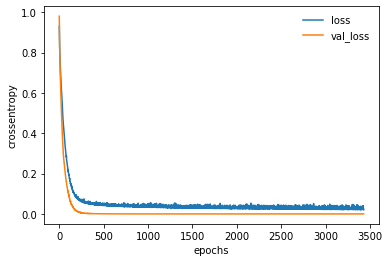

In [41]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False)
plt.xlabel('epochs')
plt.ylabel('crossentropy')
plt.show()

In [42]:
Y_pred = model.predict_classes(X_test)

In [43]:
Y_pred

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 0,
       0])

In [44]:
Y_test_ = np.argmax(Y_test, axis=1)

In [46]:
from sklearn.metrics import classification_report

print(classification_report(Y_test_, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



In [47]:
# Y：目的変数、X：説明変数
Y = np.array(dataset['species'])
X = np.array(dataset[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])

In [48]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [49]:
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Dense(16, activation='relu', input_shape=(4,)))
# 隠れ層
model.add(Dense(16, activation='relu'))
# 出力層
model.add(Dense(3, activation='softmax'))

# モデルの構築
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [50]:
# 学習の実施
log = model.fit(X_train, Y_train, epochs=5000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=100,
                                                         verbose=1)],
                validation_data=(X_valid, Y_valid))

Train on 73 samples, validate on 32 samples
Epoch 1/5000
73/73 [==============================] - 1s 10ms/sample - loss: 1.3953 - accuracy: 0.2603 - val_loss: 1.1896 - val_accuracy: 0.4688
Epoch 2/5000
73/73 [==============================] - 0s 204us/sample - loss: 1.2981 - accuracy: 0.2877 - val_loss: 1.1451 - val_accuracy: 0.5938
Epoch 3/5000
73/73 [==============================] - 0s 198us/sample - loss: 1.2329 - accuracy: 0.4521 - val_loss: 1.1072 - val_accuracy: 0.6562
Epoch 4/5000
73/73 [==============================] - 0s 206us/sample - loss: 1.1832 - accuracy: 0.5205 - val_loss: 1.0808 - val_accuracy: 0.6562
Epoch 5/5000
73/73 [==============================] - 0s 201us/sample - loss: 1.1471 - accuracy: 0.5479 - val_loss: 1.0640 - val_accuracy: 0.6875
Epoch 6/5000
73/73 [==============================] - 0s 204us/sample - loss: 1.1188 - accuracy: 0.5616 - val_loss: 1.0508 - val_accuracy: 0.6875
Epoch 7/5000
73/73 [==============================] - 0s 198us/sample - loss: 1.0

73/73 [==============================] - 0s 225us/sample - loss: 0.5280 - accuracy: 0.9589 - val_loss: 0.4794 - val_accuracy: 0.9375
Epoch 57/5000
73/73 [==============================] - 0s 224us/sample - loss: 0.5217 - accuracy: 0.9315 - val_loss: 0.4742 - val_accuracy: 0.8438
Epoch 58/5000
73/73 [==============================] - 0s 196us/sample - loss: 0.5119 - accuracy: 0.8356 - val_loss: 0.4638 - val_accuracy: 0.8750
Epoch 59/5000
73/73 [==============================] - 0s 238us/sample - loss: 0.5040 - accuracy: 0.8219 - val_loss: 0.4557 - val_accuracy: 0.9062
Epoch 60/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.4965 - accuracy: 0.7945 - val_loss: 0.4430 - val_accuracy: 0.9375
Epoch 61/5000
73/73 [==============================] - 0s 220us/sample - loss: 0.4852 - accuracy: 0.8904 - val_loss: 0.4366 - val_accuracy: 0.8750
Epoch 62/5000
73/73 [==============================] - 0s 229us/sample - loss: 0.4805 - accuracy: 0.8356 - val_loss: 0.4219 - val_ac

Epoch 112/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.2368 - accuracy: 0.9589 - val_loss: 0.1827 - val_accuracy: 0.9688
Epoch 113/5000
73/73 [==============================] - 0s 236us/sample - loss: 0.2329 - accuracy: 0.9589 - val_loss: 0.1800 - val_accuracy: 0.9688
Epoch 114/5000
73/73 [==============================] - 0s 213us/sample - loss: 0.2277 - accuracy: 0.9452 - val_loss: 0.1848 - val_accuracy: 1.0000
Epoch 115/5000
73/73 [==============================] - 0s 213us/sample - loss: 0.2324 - accuracy: 0.9726 - val_loss: 0.1744 - val_accuracy: 1.0000
Epoch 116/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.2241 - accuracy: 0.9589 - val_loss: 0.1727 - val_accuracy: 0.9688
Epoch 117/5000
73/73 [==============================] - 0s 231us/sample - loss: 0.2232 - accuracy: 0.9452 - val_loss: 0.1703 - val_accuracy: 1.0000
Epoch 118/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.2169 - accuracy: 0.9726 - val_

73/73 [==============================] - 0s 234us/sample - loss: 0.1309 - accuracy: 0.9726 - val_loss: 0.0881 - val_accuracy: 1.0000
Epoch 168/5000
73/73 [==============================] - 0s 214us/sample - loss: 0.1268 - accuracy: 0.9726 - val_loss: 0.0860 - val_accuracy: 1.0000
Epoch 169/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.1274 - accuracy: 0.9726 - val_loss: 0.0870 - val_accuracy: 1.0000
Epoch 170/5000
73/73 [==============================] - 0s 205us/sample - loss: 0.1312 - accuracy: 0.9726 - val_loss: 0.0861 - val_accuracy: 1.0000
Epoch 171/5000
73/73 [==============================] - 0s 204us/sample - loss: 0.1274 - accuracy: 0.9726 - val_loss: 0.0854 - val_accuracy: 1.0000
Epoch 172/5000
73/73 [==============================] - 0s 201us/sample - loss: 0.1251 - accuracy: 0.9726 - val_loss: 0.0826 - val_accuracy: 1.0000
Epoch 173/5000
73/73 [==============================] - 0s 204us/sample - loss: 0.1246 - accuracy: 0.9726 - val_loss: 0.0814 - 

73/73 [==============================] - 0s 233us/sample - loss: 0.0922 - accuracy: 0.9726 - val_loss: 0.0544 - val_accuracy: 1.0000
Epoch 223/5000
73/73 [==============================] - 0s 205us/sample - loss: 0.0905 - accuracy: 0.9726 - val_loss: 0.0547 - val_accuracy: 1.0000
Epoch 224/5000
73/73 [==============================] - 0s 232us/sample - loss: 0.0902 - accuracy: 0.9863 - val_loss: 0.0491 - val_accuracy: 1.0000
Epoch 225/5000
73/73 [==============================] - 0s 208us/sample - loss: 0.0919 - accuracy: 0.9726 - val_loss: 0.0672 - val_accuracy: 1.0000
Epoch 226/5000
73/73 [==============================] - 0s 205us/sample - loss: 0.0966 - accuracy: 0.9726 - val_loss: 0.0578 - val_accuracy: 1.0000
Epoch 227/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0895 - accuracy: 0.9863 - val_loss: 0.0489 - val_accuracy: 1.0000
Epoch 228/5000
73/73 [==============================] - 0s 205us/sample - loss: 0.0877 - accuracy: 0.9726 - val_loss: 0.0621 - 

73/73 [==============================] - 0s 226us/sample - loss: 0.0755 - accuracy: 0.9726 - val_loss: 0.0363 - val_accuracy: 1.0000
Epoch 278/5000
73/73 [==============================] - 0s 230us/sample - loss: 0.0759 - accuracy: 0.9726 - val_loss: 0.0523 - val_accuracy: 1.0000
Epoch 279/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.0860 - accuracy: 0.9726 - val_loss: 0.0482 - val_accuracy: 1.0000
Epoch 280/5000
73/73 [==============================] - 0s 229us/sample - loss: 0.0804 - accuracy: 0.9726 - val_loss: 0.0455 - val_accuracy: 1.0000
Epoch 281/5000
73/73 [==============================] - 0s 202us/sample - loss: 0.0768 - accuracy: 0.9863 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 282/5000
73/73 [==============================] - 0s 231us/sample - loss: 0.0758 - accuracy: 0.9863 - val_loss: 0.0348 - val_accuracy: 1.0000
Epoch 283/5000
73/73 [==============================] - 0s 229us/sample - loss: 0.0756 - accuracy: 0.9726 - val_loss: 0.0363 - 

73/73 [==============================] - 0s 223us/sample - loss: 0.0755 - accuracy: 0.9726 - val_loss: 0.0400 - val_accuracy: 1.0000
Epoch 333/5000
73/73 [==============================] - 0s 211us/sample - loss: 0.0739 - accuracy: 0.9863 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 334/5000
73/73 [==============================] - 0s 200us/sample - loss: 0.0685 - accuracy: 0.9863 - val_loss: 0.0271 - val_accuracy: 1.0000
Epoch 335/5000
73/73 [==============================] - 0s 200us/sample - loss: 0.0685 - accuracy: 0.9726 - val_loss: 0.0387 - val_accuracy: 1.0000
Epoch 336/5000
73/73 [==============================] - 0s 221us/sample - loss: 0.0699 - accuracy: 0.9863 - val_loss: 0.0291 - val_accuracy: 1.0000
Epoch 337/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.0650 - accuracy: 0.9863 - val_loss: 0.0272 - val_accuracy: 1.0000
Epoch 338/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0693 - accuracy: 0.9863 - val_loss: 0.0271 - 

73/73 [==============================] - 0s 224us/sample - loss: 0.0688 - accuracy: 0.9726 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 388/5000
73/73 [==============================] - 0s 234us/sample - loss: 0.0686 - accuracy: 0.9726 - val_loss: 0.0438 - val_accuracy: 0.9688
Epoch 389/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0715 - accuracy: 0.9863 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 390/5000
73/73 [==============================] - 0s 229us/sample - loss: 0.0611 - accuracy: 0.9863 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 391/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.0620 - accuracy: 0.9863 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 392/5000
73/73 [==============================] - 0s 232us/sample - loss: 0.0674 - accuracy: 0.9726 - val_loss: 0.0270 - val_accuracy: 1.0000
Epoch 393/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0653 - accuracy: 0.9863 - val_loss: 0.0356 - 

73/73 [==============================] - 0s 207us/sample - loss: 0.0626 - accuracy: 0.9726 - val_loss: 0.0300 - val_accuracy: 1.0000
Epoch 443/5000
73/73 [==============================] - 0s 202us/sample - loss: 0.0663 - accuracy: 0.9863 - val_loss: 0.0382 - val_accuracy: 0.9688
Epoch 444/5000
73/73 [==============================] - 0s 201us/sample - loss: 0.0671 - accuracy: 0.9863 - val_loss: 0.0259 - val_accuracy: 1.0000
Epoch 445/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0617 - accuracy: 0.9863 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 446/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0647 - accuracy: 0.9726 - val_loss: 0.0199 - val_accuracy: 1.0000
Epoch 447/5000
73/73 [==============================] - 0s 232us/sample - loss: 0.0619 - accuracy: 0.9863 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 448/5000
73/73 [==============================] - 0s 234us/sample - loss: 0.0612 - accuracy: 0.9726 - val_loss: 0.0215 - 

73/73 [==============================] - 0s 243us/sample - loss: 0.0571 - accuracy: 0.9726 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 498/5000
73/73 [==============================] - 0s 253us/sample - loss: 0.0551 - accuracy: 0.9726 - val_loss: 0.0360 - val_accuracy: 0.9688
Epoch 499/5000
73/73 [==============================] - 0s 298us/sample - loss: 0.0589 - accuracy: 0.9863 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 500/5000
73/73 [==============================] - 0s 260us/sample - loss: 0.0653 - accuracy: 0.9726 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 501/5000
73/73 [==============================] - 0s 282us/sample - loss: 0.0582 - accuracy: 0.9726 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 502/5000
73/73 [==============================] - 0s 265us/sample - loss: 0.0556 - accuracy: 0.9863 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 503/5000
73/73 [==============================] - 0s 279us/sample - loss: 0.0590 - accuracy: 0.9726 - val_loss: 0.0178 - 

73/73 [==============================] - 0s 243us/sample - loss: 0.0568 - accuracy: 0.9726 - val_loss: 0.0175 - val_accuracy: 1.0000
Epoch 553/5000
73/73 [==============================] - 0s 244us/sample - loss: 0.0528 - accuracy: 0.9863 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 554/5000
73/73 [==============================] - 0s 249us/sample - loss: 0.0651 - accuracy: 0.9726 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 555/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.0561 - accuracy: 0.9863 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 556/5000
73/73 [==============================] - 0s 270us/sample - loss: 0.0530 - accuracy: 0.9863 - val_loss: 0.0147 - val_accuracy: 1.0000
Epoch 557/5000
73/73 [==============================] - 0s 259us/sample - loss: 0.0607 - accuracy: 0.9726 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 558/5000
73/73 [==============================] - 0s 214us/sample - loss: 0.0533 - accuracy: 0.9726 - val_loss: 0.0165 - 

73/73 [==============================] - 0s 206us/sample - loss: 0.0506 - accuracy: 0.9863 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 608/5000
73/73 [==============================] - 0s 213us/sample - loss: 0.0616 - accuracy: 0.9726 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 609/5000
73/73 [==============================] - 0s 210us/sample - loss: 0.0548 - accuracy: 0.9726 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 610/5000
73/73 [==============================] - 0s 202us/sample - loss: 0.0554 - accuracy: 0.9726 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 611/5000
73/73 [==============================] - 0s 200us/sample - loss: 0.0565 - accuracy: 0.9863 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 612/5000
73/73 [==============================] - 0s 228us/sample - loss: 0.0568 - accuracy: 0.9726 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 613/5000
73/73 [==============================] - 0s 226us/sample - loss: 0.0523 - accuracy: 0.9726 - val_loss: 0.0355 - 

73/73 [==============================] - 0s 215us/sample - loss: 0.0580 - accuracy: 0.9863 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 663/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0562 - accuracy: 0.9726 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 664/5000
73/73 [==============================] - 0s 204us/sample - loss: 0.0514 - accuracy: 0.9863 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 665/5000
73/73 [==============================] - 0s 233us/sample - loss: 0.0512 - accuracy: 0.9726 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 666/5000
73/73 [==============================] - 0s 203us/sample - loss: 0.0513 - accuracy: 0.9726 - val_loss: 0.0282 - val_accuracy: 1.0000
Epoch 667/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0551 - accuracy: 0.9863 - val_loss: 0.0191 - val_accuracy: 1.0000
Epoch 668/5000
73/73 [==============================] - 0s 244us/sample - loss: 0.0522 - accuracy: 0.9863 - val_loss: 0.0173 - 

73/73 [==============================] - 0s 213us/sample - loss: 0.0579 - accuracy: 0.9726 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 718/5000
73/73 [==============================] - 0s 209us/sample - loss: 0.0510 - accuracy: 0.9863 - val_loss: 0.0149 - val_accuracy: 1.0000
Epoch 719/5000
73/73 [==============================] - 0s 215us/sample - loss: 0.0625 - accuracy: 0.9726 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 720/5000
73/73 [==============================] - 0s 216us/sample - loss: 0.0558 - accuracy: 0.9726 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 721/5000
73/73 [==============================] - 0s 214us/sample - loss: 0.0576 - accuracy: 0.9726 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 722/5000
73/73 [==============================] - 0s 228us/sample - loss: 0.0492 - accuracy: 0.9726 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 723/5000
73/73 [==============================] - 0s 220us/sample - loss: 0.0512 - accuracy: 0.9726 - val_loss: 0.0113 - 

73/73 [==============================] - 0s 237us/sample - loss: 0.0546 - accuracy: 0.9726 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 773/5000
73/73 [==============================] - 0s 234us/sample - loss: 0.0496 - accuracy: 0.9726 - val_loss: 0.0284 - val_accuracy: 0.9688
Epoch 774/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0592 - accuracy: 0.9726 - val_loss: 0.0336 - val_accuracy: 0.9688
Epoch 775/5000
73/73 [==============================] - 0s 233us/sample - loss: 0.0611 - accuracy: 0.9726 - val_loss: 0.0352 - val_accuracy: 0.9688
Epoch 776/5000
73/73 [==============================] - 0s 216us/sample - loss: 0.0557 - accuracy: 0.9589 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 777/5000
73/73 [==============================] - 0s 210us/sample - loss: 0.0503 - accuracy: 0.9726 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 778/5000
73/73 [==============================] - 0s 215us/sample - loss: 0.0565 - accuracy: 0.9726 - val_loss: 0.0105 - 

73/73 [==============================] - 0s 233us/sample - loss: 0.0557 - accuracy: 0.9863 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 828/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0532 - accuracy: 0.9863 - val_loss: 0.0254 - val_accuracy: 1.0000
Epoch 829/5000
73/73 [==============================] - 0s 230us/sample - loss: 0.0481 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 830/5000
73/73 [==============================] - 0s 238us/sample - loss: 0.0449 - accuracy: 0.9726 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 831/5000
73/73 [==============================] - 0s 246us/sample - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 832/5000
73/73 [==============================] - 0s 226us/sample - loss: 0.0542 - accuracy: 0.9726 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 833/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.0474 - accuracy: 1.0000 - val_loss: 0.0136 - 

73/73 [==============================] - 0s 205us/sample - loss: 0.0585 - accuracy: 0.9726 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 883/5000
73/73 [==============================] - 0s 204us/sample - loss: 0.0521 - accuracy: 0.9726 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 884/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0464 - accuracy: 0.9863 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 885/5000
73/73 [==============================] - 0s 235us/sample - loss: 0.0587 - accuracy: 0.9726 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 886/5000
73/73 [==============================] - 0s 244us/sample - loss: 0.0518 - accuracy: 0.9726 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 887/5000
73/73 [==============================] - 0s 221us/sample - loss: 0.0507 - accuracy: 0.9863 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 888/5000
73/73 [==============================] - 0s 253us/sample - loss: 0.0494 - accuracy: 0.9726 - val_loss: 0.0265 - 

73/73 [==============================] - 0s 198us/sample - loss: 0.0514 - accuracy: 0.9726 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 938/5000
73/73 [==============================] - 0s 242us/sample - loss: 0.0458 - accuracy: 0.9863 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 939/5000
73/73 [==============================] - 0s 226us/sample - loss: 0.0433 - accuracy: 0.9863 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 940/5000
73/73 [==============================] - 0s 216us/sample - loss: 0.0494 - accuracy: 0.9726 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 941/5000
73/73 [==============================] - 0s 217us/sample - loss: 0.0453 - accuracy: 0.9726 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 942/5000
73/73 [==============================] - 0s 220us/sample - loss: 0.0425 - accuracy: 0.9863 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 943/5000
73/73 [==============================] - 0s 211us/sample - loss: 0.0535 - accuracy: 0.9726 - val_loss: 0.0366 - 

73/73 [==============================] - 0s 240us/sample - loss: 0.0476 - accuracy: 0.9726 - val_loss: 0.0290 - val_accuracy: 0.9688
Epoch 993/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0454 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 994/5000
73/73 [==============================] - 0s 228us/sample - loss: 0.0561 - accuracy: 0.9726 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 995/5000
73/73 [==============================] - 0s 197us/sample - loss: 0.0554 - accuracy: 0.9726 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 996/5000
73/73 [==============================] - 0s 201us/sample - loss: 0.0511 - accuracy: 0.9726 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 997/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0414 - accuracy: 0.9863 - val_loss: 0.0156 - val_accuracy: 1.0000
Epoch 998/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0524 - accuracy: 0.9726 - val_loss: 0.0081 - 

73/73 [==============================] - 0s 231us/sample - loss: 0.0540 - accuracy: 0.9726 - val_loss: 0.0322 - val_accuracy: 0.9688
Epoch 1048/5000
73/73 [==============================] - 0s 232us/sample - loss: 0.0493 - accuracy: 0.9726 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 1049/5000
73/73 [==============================] - 0s 201us/sample - loss: 0.0447 - accuracy: 0.9726 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 1050/5000
73/73 [==============================] - 0s 200us/sample - loss: 0.0411 - accuracy: 0.9863 - val_loss: 0.0149 - val_accuracy: 1.0000
Epoch 1051/5000
73/73 [==============================] - 0s 231us/sample - loss: 0.0427 - accuracy: 0.9863 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 1052/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0422 - accuracy: 0.9726 - val_loss: 0.0337 - val_accuracy: 0.9688
Epoch 1053/5000
73/73 [==============================] - 0s 234us/sample - loss: 0.0654 - accuracy: 0.9726 - val_loss: 0.0

73/73 [==============================] - 0s 203us/sample - loss: 0.0436 - accuracy: 0.9863 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 1103/5000
73/73 [==============================] - 0s 200us/sample - loss: 0.0411 - accuracy: 0.9863 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 1104/5000
73/73 [==============================] - 0s 200us/sample - loss: 0.0459 - accuracy: 0.9726 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 1105/5000
73/73 [==============================] - 0s 241us/sample - loss: 0.0452 - accuracy: 0.9726 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 1106/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0404 - accuracy: 0.9726 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 1107/5000
73/73 [==============================] - 0s 243us/sample - loss: 0.0427 - accuracy: 0.9863 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 1108/5000
73/73 [==============================] - 0s 217us/sample - loss: 0.0437 - accuracy: 0.9726 - val_loss: 0.0

73/73 [==============================] - 0s 208us/sample - loss: 0.0422 - accuracy: 0.9726 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 1158/5000
73/73 [==============================] - 0s 208us/sample - loss: 0.0485 - accuracy: 0.9726 - val_loss: 0.0175 - val_accuracy: 1.0000
Epoch 1159/5000
73/73 [==============================] - 0s 210us/sample - loss: 0.0391 - accuracy: 0.9863 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 1160/5000
73/73 [==============================] - 0s 212us/sample - loss: 0.0481 - accuracy: 0.9726 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 1161/5000
73/73 [==============================] - 0s 239us/sample - loss: 0.0442 - accuracy: 0.9726 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 1162/5000
73/73 [==============================] - 0s 204us/sample - loss: 0.0408 - accuracy: 0.9726 - val_loss: 0.0415 - val_accuracy: 0.9688
Epoch 1163/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.0715 - accuracy: 0.9452 - val_loss: 0.0

73/73 [==============================] - 0s 232us/sample - loss: 0.0531 - accuracy: 0.9726 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 1213/5000
73/73 [==============================] - 0s 206us/sample - loss: 0.0463 - accuracy: 0.9726 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 1214/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0539 - accuracy: 0.9726 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 1215/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0442 - accuracy: 0.9726 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 1216/5000
73/73 [==============================] - 0s 207us/sample - loss: 0.0530 - accuracy: 0.9726 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 1217/5000
73/73 [==============================] - 0s 228us/sample - loss: 0.0433 - accuracy: 0.9726 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 1218/5000
73/73 [==============================] - 0s 240us/sample - loss: 0.0380 - accuracy: 0.9863 - val_loss: 0.0

73/73 [==============================] - 0s 203us/sample - loss: 0.0466 - accuracy: 0.9863 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 1268/5000
73/73 [==============================] - 0s 203us/sample - loss: 0.0391 - accuracy: 0.9863 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 1269/5000
73/73 [==============================] - 0s 229us/sample - loss: 0.0460 - accuracy: 0.9726 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 1270/5000
73/73 [==============================] - 0s 225us/sample - loss: 0.0374 - accuracy: 0.9863 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 1271/5000
73/73 [==============================] - 0s 238us/sample - loss: 0.0374 - accuracy: 0.9863 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 1272/5000
73/73 [==============================] - 0s 237us/sample - loss: 0.0380 - accuracy: 0.9863 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 1273/5000
73/73 [==============================] - 0s 240us/sample - loss: 0.0419 - accuracy: 0.9726 - val_loss: 0.0

73/73 [==============================] - 0s 220us/sample - loss: 0.0393 - accuracy: 0.9863 - val_loss: 0.0396 - val_accuracy: 0.9688
Epoch 1323/5000
73/73 [==============================] - 0s 218us/sample - loss: 0.0460 - accuracy: 0.9863 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 1324/5000
73/73 [==============================] - 0s 201us/sample - loss: 0.0479 - accuracy: 0.9863 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 1325/5000
73/73 [==============================] - 0s 229us/sample - loss: 0.0494 - accuracy: 0.9726 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 1326/5000
73/73 [==============================] - 0s 230us/sample - loss: 0.0379 - accuracy: 0.9726 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 1327/5000
73/73 [==============================] - 0s 202us/sample - loss: 0.0398 - accuracy: 0.9863 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 1328/5000
73/73 [==============================] - 0s 227us/sample - loss: 0.0459 - accuracy: 0.9726 - val_loss: 0.0

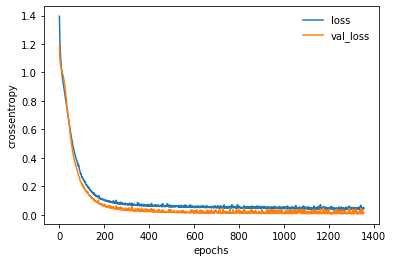

In [51]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False)
plt.xlabel('epochs')
plt.ylabel('crossentropy')
plt.show()

In [52]:
Y_pred = model.predict_classes(X_test)

In [53]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

